In [1]:
import pandas as pd
import os, json
import glob
import numpy as np
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap, Normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.utils import resample

/var/folders/fp/5_bj1cjn7s1851d6x2k9fz8m0000gn/T/ipykernel_5282/3770916551.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
temp = pd.DataFrame()

path_to_json = '/Users/emrecanduygulu/Downloads/scraping/shotmap_files' 

json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

In [3]:
dfs = []
for file in file_list:
    with open(file) as f:
        json_data = pd.json_normalize(json.loads(f.read()))
    dfs.append(json_data)
df = pd.concat(dfs, ignore_index=True)

In [4]:
df.sample()

isHome shotType situation   bodyPart goalMouthLocation        xg  \
577    True     miss  assisted  left-foot         high-left  0.016453   

          id  time  addedTime  timeSeconds  ...  draw.block.y  draw.end.x  \
577  3420501   105        NaN         6270  ...           NaN        41.2   

    draw.end.y draw.goal.x draw.goal.y player.firstName player.lastName xgot  \
577          0        41.2        34.7                                   NaN   

     goalType  shootoutOrder  
577       NaN            NaN  

[1 rows x 44 columns]

In [5]:
df.describe()

xg            id         time   addedTime  timeSeconds  \
count  1321.000000  1.331000e+03  1331.000000  118.000000  1331.000000   
mean      0.114339  3.391752e+06    53.476334    2.974576  3194.592787   
std       0.164817  2.359442e+04    29.573586    2.035841  1792.172175   
min       0.006007  3.348944e+06     1.000000    1.000000    11.000000   
25%       0.026372  3.379020e+06    29.000000    1.000000  1701.000000   
50%       0.051632  3.391138e+06    53.000000    2.000000  3165.000000   
75%       0.123150  3.409851e+06    77.000000    4.000000  4581.500000   
max       0.902668  3.447457e+06   128.000000   10.000000  7639.000000   

       reversedPeriodTime  reversedPeriodTimeSeconds  player.userCount  \
count         1331.000000                1331.000000       1331.000000   
mean            20.269722                1289.178813      54771.943651   
std             13.669685                 782.175647     142451.367969   
min              1.000000                   0.000000         86.000000   
25%              8.000000                 641.000000       2338.000000   
50%             19.000000                1222.000000       7811.000000   
75%             32.500000                1983.000000      39644.000000   
max             45.000000                2699.000000     935857.000000   

          player.id  playerCoordinates.x  ...  draw.start.x  draw.start.y  \
count  1.331000e+03          1331.000000  ...   1331.000000   1331.000000   
mean   5.937843e+05            14.886852  ...     49.420361     14.886852   
std    3.838508e+05             7.960816  ...     12.262148      7.960816   
min    7.500000e+02             1.200000  ...      6.100000      1.200000   
25%    1.515450e+05             8.700000  ...     40.800000      8.700000   
50%    7.956960e+05            13.200000  ...     49.700000     13.200000   
75%    8.935490e+05            21.200000  ...     57.300000     21.200000   
max    1.402912e+06            61.300000  ...     83.800000     61.300000   

       draw.block.x  draw.block.y   draw.end.x  draw.end.y  draw.goal.x  \
count    773.000000    773.000000  1331.000000      1331.0  1331.000000   
mean      49.906339      7.272574    49.991510         0.0    49.991510   
std        9.437619      6.370318     8.521731         0.0     8.521731   
min        0.000000      0.000000     0.200000         0.0     0.200000   
25%       46.400000      1.800000    47.000000         0.0    47.000000   
50%       49.800000      5.400000    49.700000         0.0    49.700000   
75%       53.400000     11.600000    52.800000         0.0    52.800000   
max      100.000000     26.300000    99.700000         0.0    99.700000   

       draw.goal.y        xgot  shootoutOrder  
count  1331.000000  440.000000      24.000000  
mean     76.635162    0.369081       2.583333  
std      22.237092    0.328586       1.282547  
min       0.000000    0.013000       1.000000  
25%      75.900000    0.079875       1.750000  
50%      81.000000    0.253600       2.500000  
75%      91.700000    0.638125       3.250000  
max      99.400000    0.997100       5.000000  

[8 rows x 28 columns]

In [6]:
df.head(5)

isHome shotType situation    bodyPart goalMouthLocation        xg       id  \
0    True     miss  assisted  right-foot              left  0.049185  3358405   
1    True     miss    corner   left-foot         high-left  0.040552  3358403   
2    True     miss    corner        head             right  0.016461  3358398   
3    True    block  assisted  right-foot          low-left  0.057927  3358395   
4   False     miss  assisted   left-foot              left  0.040486  3358393   

   time  addedTime  timeSeconds  ...  draw.block.y  draw.end.x draw.end.y  \
0    90        3.0         5566  ...           8.0        32.6          0   
1    90        1.0         5443  ...           NaN        28.4          0   
2    80        NaN         4794  ...           NaN        61.3          0   
3    80        NaN         4758  ...          17.1        48.1          0   
4    78        NaN         4672  ...           NaN        26.7          0   

  draw.goal.x draw.goal.y player.firstName player.lastName xgot  goalType  \
0        32.6        93.1              NaN             NaN  NaN       NaN   
1        28.4        59.7   Johan Bakayoko                  NaN       NaN   
2        61.3        88.9              NaN             NaN  NaN       NaN   
3        48.1        81.9                                   NaN       NaN   
4        26.7        91.7              NaN             NaN  NaN       NaN   

   shootoutOrder  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 44 columns]

In [7]:
new_df = df.copy()

In [ ]:
player_columns = [col for col in new_df.columns if col.startswith('player')]

other_columns = [col for col in new_df.columns if not col.startswith('player')]

new_df["shot_id"] = new_df.index
cols = ["shot_id"]
new_column_order = cols + player_columns + other_columns

new_df = new_df[new_column_order]

In [ ]:
new_df["shot_id"].nunique()

1331

In [10]:
new_df

shot_id         player.name         player.slug player.shortName  \
0           0     Kevin De Bruyne     kevin-de-bruyne     K. De Bruyne   
1           1      Johan Bakayoko      johan-bakayoko      J. Bakayoko   
2           2        Amadou Onana        amadou-onana         A. Onana   
3           3    Yannick Carrasco    yannick-carrasco      Y. Carrasco   
4           4         Juraj Kucka         juraj-kucka         J. Kucka   
...       ...                 ...                 ...              ...   
1326     1326       Mateo Retegui       mateo-retegui       M. Retegui   
1327     1327       Mateo Retegui       mateo-retegui       M. Retegui   
1328     1328       Mateo Retegui       mateo-retegui       M. Retegui   
1329     1329  Lorenzo Pellegrini  lorenzo-pellegrini    L. Pellegrini   
1330     1330          Luka Sučić          luka-sucic         L. Sučić   

     player.position player.jerseyNumber  player.userCount  player.id  \
0                  M                  17            251026      70996   
1                  F                  11              5555    1088896   
2                  M                   8              4774     923973   
3                  M                  23              7199     182001   
4                  M                  33               762      48563   
...              ...                 ...               ...        ...   
1326               F                  19              4184     914501   
1327               F                  19              4184     914501   
1328               F                  19              4184     914501   
1329               M                   7              6743     555540   
1330               M                  10              4276     949156   

     player.fieldTranslations.nameTranslation.ar  \
0                                دي بروين, كيفين   
1                                   جون باكايوكو   
2                            أونانا ، أمادو مفوم   
3                                  يانيك كاراسكو   
4                                      كوك يوراي   
...                                          ...   
1326                                     ريتيجوي   
1327                                     ريتيجوي   
1328                                     ريتيجوي   
1329                            لورنزو بيليجريني   
1330                                لوكا سوتشيتش   

     player.fieldTranslations.shortNameTranslation.ar  ...  draw.start.y  \
0                                         ك. د. بروين  ...           9.1   
1                                         ج. باكايوكو  ...          19.5   
2                                        أ. ، أ. مفوم  ...          11.4   
3                                          ي. كاراسكو  ...          20.1   
4                                            ك. يوراي  ...          23.1   
...                                               ...  ...           ...   
1326                                          ريتيجوي  ...           7.9   
1327                                          ريتيجوي  ...          13.8   
1328                                          ريتيجوي  ...           7.6   
1329                                     ل. بيليجريني  ...          13.6   
1330                                       ل. سوتشيتش  ...          25.9   

      draw.block.x  draw.block.y draw.end.x draw.end.y  draw.goal.x  \
0             59.2           8.0       32.6          0         32.6   
1              NaN           NaN       28.4          0         28.4   
2              NaN           NaN       61.3          0         61.3   
3             45.5          17.1       48.1          0         48.1   
4              NaN           NaN       26.7          0         26.7   
...            ...           ...        ...        ...          ...   
1326          32.7           7.3       45.5          0         45.5   
1327          46.9          11.9       50.1          0         50.1   
1328          53.1           6.2       50.4          0         

In [11]:
new_df.to_csv('out.csv', index=False)

In [12]:
new_df.set_index("shot_id", inplace=True)

In [13]:
new_df.head(5)

player.name       player.slug player.shortName player.position  \
shot_id                                                                        
0         Kevin De Bruyne   kevin-de-bruyne     K. De Bruyne               M   
1          Johan Bakayoko    johan-bakayoko      J. Bakayoko               F   
2            Amadou Onana      amadou-onana         A. Onana               M   
3        Yannick Carrasco  yannick-carrasco      Y. Carrasco               M   
4             Juraj Kucka       juraj-kucka         J. Kucka               M   

        player.jerseyNumber  player.userCount  player.id  \
shot_id                                                    
0                        17            251026      70996   
1                        11              5555    1088896   
2                         8              4774     923973   
3                        23              7199     182001   
4                        33               762      48563   

        player.fieldTranslations.nameTranslation.ar  \
shot_id                                               
0                                   دي بروين, كيفين   
1                                      جون باكايوكو   
2                               أونانا ، أمادو مفوم   
3                                     يانيك كاراسكو   
4                                         كوك يوراي   

        player.fieldTranslations.shortNameTranslation.ar  playerCoordinates.x  \
shot_id                                                                         
0                                            ك. د. بروين                  9.1   
1                                            ج. باكايوكو                 19.5   
2                                           أ. ، أ. مفوم                 11.4   
3                                             ي. كاراسكو                 20.1   
4                                               ك. يوراي                 23.1   

         ...  draw.start.y  draw.block.x draw.block.y draw.end.x  draw.end.y  \
shot_id  ...                                                                   
0        ...           9.1          59.2          8.0       32.6           0   
1        ...          19.5           NaN          NaN       28.4           0   
2        ...          11.4           NaN          NaN       61.3           0   
3        ...          20.1          45.5         17.1       48.1           0   
4        ...          23.1           NaN          NaN       26.7           0   

        draw.goal.x draw.goal.y xgot goalType  shootoutOrder  
shot_id                                                       
0              32.6        93.1  NaN      NaN            NaN  
1              28.4        59.7  NaN      NaN            NaN  
2              61.3        88.9  NaN      NaN            NaN  
3              48.1        81.9  NaN      NaN            NaN  
4              26.7        91.7  NaN      NaN            NaN  

[5 rows x 44 columns]

In [14]:
new_df.drop(['player.fieldTranslations.nameTranslation.ar', 'player.fieldTranslations.shortNameTranslation.ar', "player.userCount", "player.jerseyNumber", "id", "player.firstName", "player.lastName", "playerCoordinates.z", "incidentType", "goalMouthCoordinates.x", "shootoutOrder"], axis=1, inplace=True)

In [15]:
new_df.head()

player.name       player.slug player.shortName player.position  \
shot_id                                                                        
0         Kevin De Bruyne   kevin-de-bruyne     K. De Bruyne               M   
1          Johan Bakayoko    johan-bakayoko      J. Bakayoko               F   
2            Amadou Onana      amadou-onana         A. Onana               M   
3        Yannick Carrasco  yannick-carrasco      Y. Carrasco               M   
4             Juraj Kucka       juraj-kucka         J. Kucka               M   

         player.id  playerCoordinates.x  playerCoordinates.y  isHome shotType  \
shot_id                                                                         
0            70996                  9.1                 65.4    True     miss   
1          1088896                 19.5                 59.3    True     miss   
2           923973                 11.4                 43.0    True     miss   
3           182001                 20.1                 44.8    True    block   
4            48563                 23.1                 63.2   False     miss   

        situation  ... draw.start.x draw.start.y  draw.block.x  draw.block.y  \
shot_id            ...                                                         
0        assisted  ...         65.4          9.1          59.2           8.0   
1          corner  ...         59.3         19.5           NaN           NaN   
2          corner  ...         43.0         11.4           NaN           NaN   
3        assisted  ...         44.8         20.1          45.5          17.1   
4        assisted  ...         63.2         23.1           NaN           NaN   

         draw.end.x  draw.end.y  draw.goal.x  draw.goal.y  xgot  goalType  
shot_id                                                                    
0              32.6           0         32.6         93.1   NaN       NaN  
1              28.4           0         28.4         59.7   NaN       NaN  
2              61.3           0         61.3         88.9   NaN       NaN  
3              48.1           0         48.1         81.9   NaN       NaN  
4              26.7           0         26.7         91.7   NaN       NaN  

[5 rows x 33 columns]

In [16]:
display(new_df.iloc[0])

player.name                  Kevin De Bruyne
player.slug                  kevin-de-bruyne
player.shortName                K. De Bruyne
player.position                            M
player.id                              70996
playerCoordinates.x                      9.1
playerCoordinates.y                     65.4
isHome                                  True
shotType                                miss
situation                           assisted
bodyPart                          right-foot
goalMouthLocation                       left
xg                                  0.049185
time                                      90
addedTime                                3.0
timeSeconds                             5566
reversedPeriodTime                         1
reversedPeriodTimeSeconds                734
goalMouthCoordinates.y                  67.4
goalMouthCoordinates.z                   6.9
blockCoordinates.x                       8.0
blockCoordinates.y                      59.2
blockCoord

In [17]:
new_df

player.name         player.slug player.shortName  \
shot_id                                                            
0           Kevin De Bruyne     kevin-de-bruyne     K. De Bruyne   
1            Johan Bakayoko      johan-bakayoko      J. Bakayoko   
2              Amadou Onana        amadou-onana         A. Onana   
3          Yannick Carrasco    yannick-carrasco      Y. Carrasco   
4               Juraj Kucka         juraj-kucka         J. Kucka   
...                     ...                 ...              ...   
1326          Mateo Retegui       mateo-retegui       M. Retegui   
1327          Mateo Retegui       mateo-retegui       M. Retegui   
1328          Mateo Retegui       mateo-retegui       M. Retegui   
1329     Lorenzo Pellegrini  lorenzo-pellegrini    L. Pellegrini   
1330             Luka Sučić          luka-sucic         L. Sučić   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
0                     M      70996                  9.1                 65.4   
1                     F    1088896                 19.5                 59.3   
2                     M     923973                 11.4                 43.0   
3                     M     182001                 20.1                 44.8   
4                     M      48563                 23.1                 63.2   
...                 ...        ...                  ...                  ...   
1326                  F     914501                  7.9                 31.8   
1327                  F     914501                 13.8                 47.0   
1328                  F     914501                  7.6                 53.4   
1329                  M     555540                 13.6                 35.1   
1330                  M     949156                 25.9                 64.0   

         isHome shotType situation  ... draw.start.x draw.start.y  \
shot_id                             ...                             
0          True     miss  assisted  ...         65.4          9.1   
1          True     miss    corner  ...         59.3         19.5   
2          True     miss    corner  ...         43.0         11.4   
3          True    block  assisted  ...         44.8         20.1   
4         False     miss  assisted  ...         63.2         23.1   
...         ...      ...       ...  ...          ...          ...   
1326      False    block  assisted  ...         31.8          7.9   
1327      False    block    corner  ...         47.0         13.8   
1328      False    block  assisted  ...         53.4          7.6   
1329      False     miss  assisted  ...         35.1         13.6   
1330       True     save  assisted  ...         64.0         25.9   

         draw.block.x  draw.block.y  draw.end.x  draw.end.y  draw.goal.x  \
shot_id                                                                    
0                59.2           8.0        32.6           0         32.6   
1                 NaN           NaN        28.4           0         28.4   
2                 NaN           NaN        61.3           0         61.3   
3                45.5          17.1        48.1           0         48.1   
4                 NaN           NaN        26.7           0         26.7   
...               ...           ...         ...         ...          ...   
1326             32.7           7.3        45.5           0         45.5   
1327             46.9          11.9        50.1           0         50.1   
1328             53.1           6.2        50.4           0         50.4   
1329              NaN           NaN        29.4           0         29.4   
1330             51.1           2.0        47.4           0         47.4   

         draw.goal.y    xgot  goalType  
shot_id                                 
0               93.1     NaN       NaN  
1               59.7     NaN       NaN  
2               88.9     NaN       NaN 

In [18]:
new_df.columns

Index(['player.name', 'player.slug', 'player.shortName', 'player.position',
       'player.id', 'playerCoordinates.x', 'playerCoordinates.y', 'isHome',
       'shotType', 'situation', 'bodyPart', 'goalMouthLocation', 'xg', 'time',
       'addedTime', 'timeSeconds', 'reversedPeriodTime',
       'reversedPeriodTimeSeconds', 'goalMouthCoordinates.y',
       'goalMouthCoordinates.z', 'blockCoordinates.x', 'blockCoordinates.y',
       'blockCoordinates.z', 'draw.start.x', 'draw.start.y', 'draw.block.x',
       'draw.block.y', 'draw.end.x', 'draw.end.y', 'draw.goal.x',
       'draw.goal.y', 'xgot', 'goalType'],
      dtype='object')

In [19]:
new_df.head()

player.name       player.slug player.shortName player.position  \
shot_id                                                                        
0         Kevin De Bruyne   kevin-de-bruyne     K. De Bruyne               M   
1          Johan Bakayoko    johan-bakayoko      J. Bakayoko               F   
2            Amadou Onana      amadou-onana         A. Onana               M   
3        Yannick Carrasco  yannick-carrasco      Y. Carrasco               M   
4             Juraj Kucka       juraj-kucka         J. Kucka               M   

         player.id  playerCoordinates.x  playerCoordinates.y  isHome shotType  \
shot_id                                                                         
0            70996                  9.1                 65.4    True     miss   
1          1088896                 19.5                 59.3    True     miss   
2           923973                 11.4                 43.0    True     miss   
3           182001                 20.1                 44.8    True    block   
4            48563                 23.1                 63.2   False     miss   

        situation  ... draw.start.x draw.start.y  draw.block.x  draw.block.y  \
shot_id            ...                                                         
0        assisted  ...         65.4          9.1          59.2           8.0   
1          corner  ...         59.3         19.5           NaN           NaN   
2          corner  ...         43.0         11.4           NaN           NaN   
3        assisted  ...         44.8         20.1          45.5          17.1   
4        assisted  ...         63.2         23.1           NaN           NaN   

         draw.end.x  draw.end.y  draw.goal.x  draw.goal.y  xgot  goalType  
shot_id                                                                    
0              32.6           0         32.6         93.1   NaN       NaN  
1              28.4           0         28.4         59.7   NaN       NaN  
2              61.3           0         61.3         88.9   NaN       NaN  
3              48.1           0         48.1         81.9   NaN       NaN  
4              26.7           0         26.7         91.7   NaN       NaN  

[5 rows x 33 columns]

In [20]:
new_df.loc[:, "playerCoordinates.x"] = 100 - new_df["playerCoordinates.x"]
new_df.loc[:, "playerCoordinates.y"] = 100 - new_df["playerCoordinates.y"]

In [21]:
#df_goals.loc[:, 'playerCoordinates.x'] = 100 - df_goals['playerCoordinates.x']
#df_goals.loc[:, 'mirrored_y'] = 100 - df_goals['playerCoordinates.y']

In [22]:
df_goals = new_df[new_df['shotType'] == 'goal']

In [23]:
df_goals.to_csv('goals.csv', index=False)

In [24]:
df_own_goals = new_df[new_df['goalType'] == 'own']

In [25]:
df_own_goals

player.name         player.slug player.shortName  \
shot_id                                                            
306      Riccardo Calafiori  riccardo-calafiori     R. Calafiori   
420           Klaus Gjasula       klaus-gjasula       K. Gjasula   
556        Maximilian Wöber    maximilian-wober         M. Wöber   
613            Robin Hranáč        robin-hranac        R. Hranáč   
673             Mert Müldür         mert-muldur        M. Müldür   
729         Antonio Rüdiger     antonio-rudiger       A. Rüdiger   
807           Samet Akaydın       samet-akaydin       S. Akaydın   
887           Donyell Malen       donyell-malen         D. Malen   
1065       Robin Le Normand    robin-le-normand    R. Le Normand   
1289         Jan Vertonghen      jan-vertonghen    J. Vertonghen   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
306                   D     957602                 95.8                 49.2   
420                   D     163673                 92.6                 52.4   
556                   D     794962                 95.2                 45.2   
613                   D     957615                 98.2                 51.4   
673                   D     836683                 93.1                 58.5   
729                   D     142622                 92.3                 46.2   
807                   D     863600                 80.3                 30.3   
887                   F     803039                 88.2                 59.3   
1065                  D     787751                 92.9                 52.8   
1289                  D      16921                 89.8                 40.1   

         isHome shotType  situation  ... draw.start.x draw.start.y  \
shot_id                              ...                             
306        True     goal    regular  ...         50.8          4.2   
420        True     goal    regular  ...         47.6          7.4   
556       False     goal    regular  ...         54.8          4.8   
613        True     goal    regular  ...         48.6          1.8   
673        True     goal    regular  ...         41.5          6.9   
729       False     goal  set-piece  ...         53.8          7.7   
807       False     goal    regular  ...         69.7         19.7   
887       False     goal    regular  ...         40.7         11.8   
1065      False     goal    regular  ...         47.2          7.1   
1289       True     goal    regular  ...         59.9         10.2   

         draw.block.x  draw.block.y  draw.end.x  draw.end.y  draw.goal.x  \
shot_id                                                                    
306               NaN           NaN        52.6           0         52.6   
420               NaN           NaN        46.4           0         46.4   
556               NaN           NaN        45.9           0         45.9   
613               NaN           NaN        48.1           0         48.1   
673               NaN           NaN        51.2           0         51.2   
729               NaN           NaN        51.0           0         51.0   
807               NaN           NaN        51.6           0         51.6   
887               NaN           NaN        47.4           0         47.4   
1065              NaN           NaN        54.3           0         54.3   
1289              NaN           NaN        53.5           0         53.5   

         draw.goal.y  xgot  goalType  
shot_id                               
306             93.0   NaN       own  
420             79.7   NaN       own  
556             93.0   NaN       own  
613             90.5   NaN       own  
673             98.1   NaN       own  
729             71.5   NaN       own  
807             98.7   NaN       own  
887             84.8   NaN       own  
1065            87.3   NaN       own  
1289            86.7   NaN       own  

[10 rows x 33 c

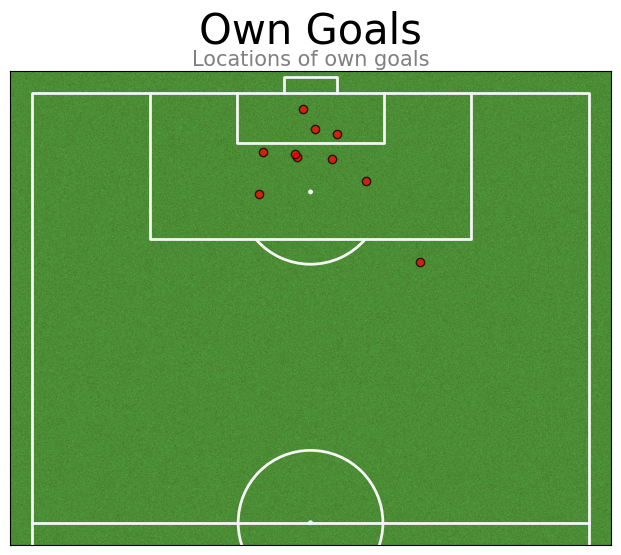

In [26]:
pitch = VerticalPitch(pitch_type='opta', pitch_color= 'grass', line_color='whitesmoke', goal_type='box',axis=True, half=True)
fig, ax = pitch.draw(figsize=(10,6))

ax.set_title('Own Goals', color='black', fontsize=30, pad=20)
fig.suptitle('Locations of own goals', fontsize=15, color='gray', y=0.85)

plt.scatter(df_own_goals['playerCoordinates.y'],df_own_goals['playerCoordinates.x'], c='red', edgecolors='black', alpha=0.75)

In [ ]:
new_df = new_df[new_df['goalType'] != 'own']

In [28]:
new_df

player.name         player.slug player.shortName  \
shot_id                                                            
0           Kevin De Bruyne     kevin-de-bruyne     K. De Bruyne   
1            Johan Bakayoko      johan-bakayoko      J. Bakayoko   
2              Amadou Onana        amadou-onana         A. Onana   
3          Yannick Carrasco    yannick-carrasco      Y. Carrasco   
4               Juraj Kucka         juraj-kucka         J. Kucka   
...                     ...                 ...              ...   
1326          Mateo Retegui       mateo-retegui       M. Retegui   
1327          Mateo Retegui       mateo-retegui       M. Retegui   
1328          Mateo Retegui       mateo-retegui       M. Retegui   
1329     Lorenzo Pellegrini  lorenzo-pellegrini    L. Pellegrini   
1330             Luka Sučić          luka-sucic         L. Sučić   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
0                     M      70996                 90.9                 34.6   
1                     F    1088896                 80.5                 40.7   
2                     M     923973                 88.6                 57.0   
3                     M     182001                 79.9                 55.2   
4                     M      48563                 76.9                 36.8   
...                 ...        ...                  ...                  ...   
1326                  F     914501                 92.1                 68.2   
1327                  F     914501                 86.2                 53.0   
1328                  F     914501                 92.4                 46.6   
1329                  M     555540                 86.4                 64.9   
1330                  M     949156                 74.1                 36.0   

         isHome shotType situation  ... draw.start.x draw.start.y  \
shot_id                             ...                             
0          True     miss  assisted  ...         65.4          9.1   
1          True     miss    corner  ...         59.3         19.5   
2          True     miss    corner  ...         43.0         11.4   
3          True    block  assisted  ...         44.8         20.1   
4         False     miss  assisted  ...         63.2         23.1   
...         ...      ...       ...  ...          ...          ...   
1326      False    block  assisted  ...         31.8          7.9   
1327      False    block    corner  ...         47.0         13.8   
1328      False    block  assisted  ...         53.4          7.6   
1329      False     miss  assisted  ...         35.1         13.6   
1330       True     save  assisted  ...         64.0         25.9   

         draw.block.x  draw.block.y  draw.end.x  draw.end.y  draw.goal.x  \
shot_id                                                                    
0                59.2           8.0        32.6           0         32.6   
1                 NaN           NaN        28.4           0         28.4   
2                 NaN           NaN        61.3           0         61.3   
3                45.5          17.1        48.1           0         48.1   
4                 NaN           NaN        26.7           0         26.7   
...               ...           ...         ...         ...          ...   
1326             32.7           7.3        45.5           0         45.5   
1327             46.9          11.9        50.1           0         50.1   
1328             53.1           6.2        50.4           0         50.4   
1329              NaN           NaN        29.4           0         29.4   
1330             51.1           2.0        47.4           0         47.4   

         draw.goal.y    xgot  goalType  
shot_id                                 
0               93.1     NaN       NaN  
1               59.7     NaN       NaN  
2               88.9     NaN       NaN 

In [29]:
new_df.drop(['goalType'], axis=1)

player.name         player.slug player.shortName  \
shot_id                                                            
0           Kevin De Bruyne     kevin-de-bruyne     K. De Bruyne   
1            Johan Bakayoko      johan-bakayoko      J. Bakayoko   
2              Amadou Onana        amadou-onana         A. Onana   
3          Yannick Carrasco    yannick-carrasco      Y. Carrasco   
4               Juraj Kucka         juraj-kucka         J. Kucka   
...                     ...                 ...              ...   
1326          Mateo Retegui       mateo-retegui       M. Retegui   
1327          Mateo Retegui       mateo-retegui       M. Retegui   
1328          Mateo Retegui       mateo-retegui       M. Retegui   
1329     Lorenzo Pellegrini  lorenzo-pellegrini    L. Pellegrini   
1330             Luka Sučić          luka-sucic         L. Sučić   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
0                     M      70996                 90.9                 34.6   
1                     F    1088896                 80.5                 40.7   
2                     M     923973                 88.6                 57.0   
3                     M     182001                 79.9                 55.2   
4                     M      48563                 76.9                 36.8   
...                 ...        ...                  ...                  ...   
1326                  F     914501                 92.1                 68.2   
1327                  F     914501                 86.2                 53.0   
1328                  F     914501                 92.4                 46.6   
1329                  M     555540                 86.4                 64.9   
1330                  M     949156                 74.1                 36.0   

         isHome shotType situation  ... blockCoordinates.z draw.start.x  \
shot_id                             ...                                   
0          True     miss  assisted  ...                0.0         65.4   
1          True     miss    corner  ...                NaN         59.3   
2          True     miss    corner  ...                NaN         43.0   
3          True    block  assisted  ...                0.0         44.8   
4         False     miss  assisted  ...                NaN         63.2   
...         ...      ...       ...  ...                ...          ...   
1326      False    block  assisted  ...                0.0         31.8   
1327      False    block    corner  ...                0.0         47.0   
1328      False    block  assisted  ...                0.0         53.4   
1329      False     miss  assisted  ...                NaN         35.1   
1330       True     save  assisted  ...                0.0         64.0   

         draw.start.y  draw.block.x  draw.block.y  draw.end.x  draw.end.y  \
shot_id                                                                     
0                 9.1          59.2           8.0        32.6           0   
1                19.5           NaN           NaN        28.4           0   
2                11.4           NaN           NaN        61.3           0   
3                20.1          45.5          17.1        48.1           0   
4                23.1           NaN           NaN        26.7           0   
...               ...           ...           ...         ...         ...   
1326              7.9          32.7           7.3        45.5           0   
1327             13.8          46.9          11.9        50.1           0   
1328              7.6          53.1           6.2        50.4           0   
1329             13.6           NaN           NaN        29.4           0   
1330             25.9          51.1           2.0        47.4           0   

         draw.goal.x  draw.goal.y    xgot  
shot_id                                    
0               32.6    

In [30]:
new_df

player.name         player.slug player.shortName  \
shot_id                                                            
0           Kevin De Bruyne     kevin-de-bruyne     K. De Bruyne   
1            Johan Bakayoko      johan-bakayoko      J. Bakayoko   
2              Amadou Onana        amadou-onana         A. Onana   
3          Yannick Carrasco    yannick-carrasco      Y. Carrasco   
4               Juraj Kucka         juraj-kucka         J. Kucka   
...                     ...                 ...              ...   
1326          Mateo Retegui       mateo-retegui       M. Retegui   
1327          Mateo Retegui       mateo-retegui       M. Retegui   
1328          Mateo Retegui       mateo-retegui       M. Retegui   
1329     Lorenzo Pellegrini  lorenzo-pellegrini    L. Pellegrini   
1330             Luka Sučić          luka-sucic         L. Sučić   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
0                     M      70996                 90.9                 34.6   
1                     F    1088896                 80.5                 40.7   
2                     M     923973                 88.6                 57.0   
3                     M     182001                 79.9                 55.2   
4                     M      48563                 76.9                 36.8   
...                 ...        ...                  ...                  ...   
1326                  F     914501                 92.1                 68.2   
1327                  F     914501                 86.2                 53.0   
1328                  F     914501                 92.4                 46.6   
1329                  M     555540                 86.4                 64.9   
1330                  M     949156                 74.1                 36.0   

         isHome shotType situation  ... draw.start.x draw.start.y  \
shot_id                             ...                             
0          True     miss  assisted  ...         65.4          9.1   
1          True     miss    corner  ...         59.3         19.5   
2          True     miss    corner  ...         43.0         11.4   
3          True    block  assisted  ...         44.8         20.1   
4         False     miss  assisted  ...         63.2         23.1   
...         ...      ...       ...  ...          ...          ...   
1326      False    block  assisted  ...         31.8          7.9   
1327      False    block    corner  ...         47.0         13.8   
1328      False    block  assisted  ...         53.4          7.6   
1329      False     miss  assisted  ...         35.1         13.6   
1330       True     save  assisted  ...         64.0         25.9   

         draw.block.x  draw.block.y  draw.end.x  draw.end.y  draw.goal.x  \
shot_id                                                                    
0                59.2           8.0        32.6           0         32.6   
1                 NaN           NaN        28.4           0         28.4   
2                 NaN           NaN        61.3           0         61.3   
3                45.5          17.1        48.1           0         48.1   
4                 NaN           NaN        26.7           0         26.7   
...               ...           ...         ...         ...          ...   
1326             32.7           7.3        45.5           0         45.5   
1327             46.9          11.9        50.1           0         50.1   
1328             53.1           6.2        50.4           0         50.4   
1329              NaN           NaN        29.4           0         29.4   
1330             51.1           2.0        47.4           0         47.4   

         draw.goal.y    xgot  goalType  
shot_id                                 
0               93.1     NaN       NaN  
1               59.7     NaN       NaN  
2               88.9     NaN       NaN 

In [31]:
new_df.to_csv('out1.csv', index=False)

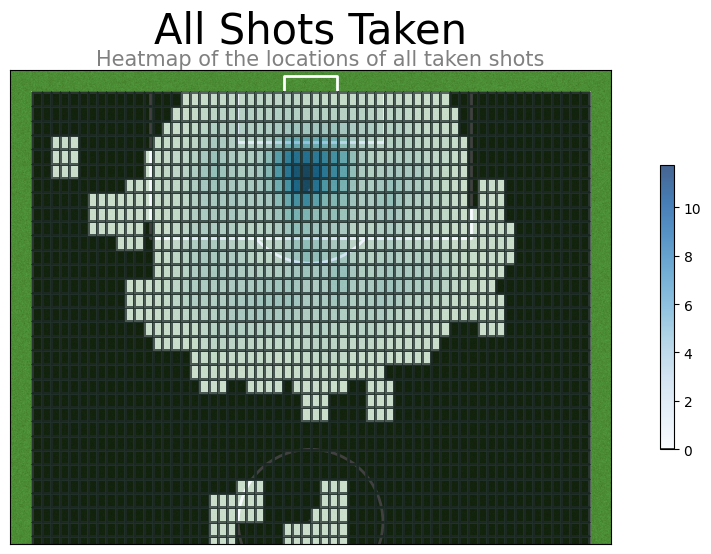

In [32]:
pitch = VerticalPitch(pitch_type='opta', pitch_color= 'grass', line_color='white', goal_type='box',axis=True, half=True)
fig, ax = pitch.draw(figsize=(10,6))

cmap = plt.get_cmap('Blues')
new_cmap = cmap(np.arange(cmap.N))
new_cmap[0, :] = np.array([0, 0, 0, 0])
new_cmap = ListedColormap(new_cmap)

bin_statistic = pitch.bin_statistic(new_df['playerCoordinates.x'], new_df['playerCoordinates.y'], statistic='count', bins=(60, 60))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
norm = Normalize(vmin=np.min(bin_statistic['statistic']), vmax=np.max(bin_statistic['statistic']), clip=True)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap=new_cmap, alpha = 0.75, norm=norm, edgecolors='#22312b')

ax.set_title('All Shots Taken', color='black', fontsize=30, pad=20)
fig.suptitle('Heatmap of the locations of all taken shots', fontsize=15, color='gray', y=0.85)


cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('black')
cbar.ax.yaxis.set_tick_params(color='black')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

Text(0.5, 0.85, 'Locations of all goals')

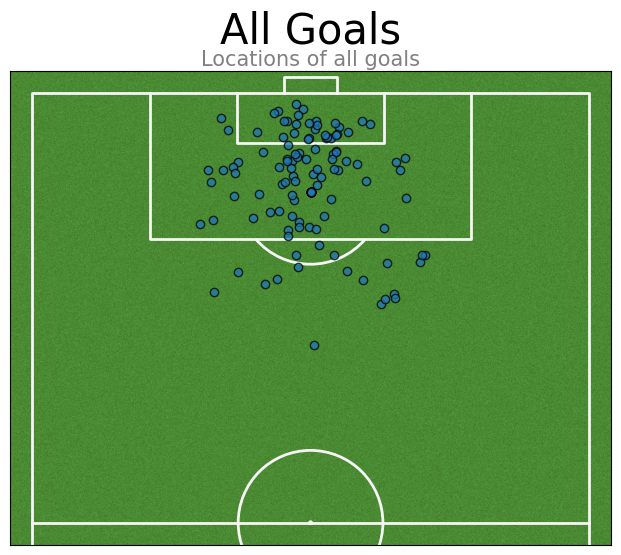

In [33]:
pitch = VerticalPitch(pitch_type='opta', pitch_color= 'grass', line_color='whitesmoke', goal_type='box',axis=True, half=True)
fig, ax = pitch.draw(figsize=(10,6))
ax.set_title('All Goals', color='black', fontsize=30, pad=20)

plt.scatter(df_goals['playerCoordinates.y'],df_goals["playerCoordinates.x"], edgecolors="black", alpha=0.75)
fig.suptitle('Locations of all goals', fontsize=15, color='gray', y=0.85)

In [ ]:
xg_by_player = new_df.groupby('player.id').agg({'xg': 'sum', 'player.shortName': 'first'}).sort_values(by='xg', ascending=False).head(20)

In [35]:
xg_by_player.set_index('player.shortName', inplace=True)

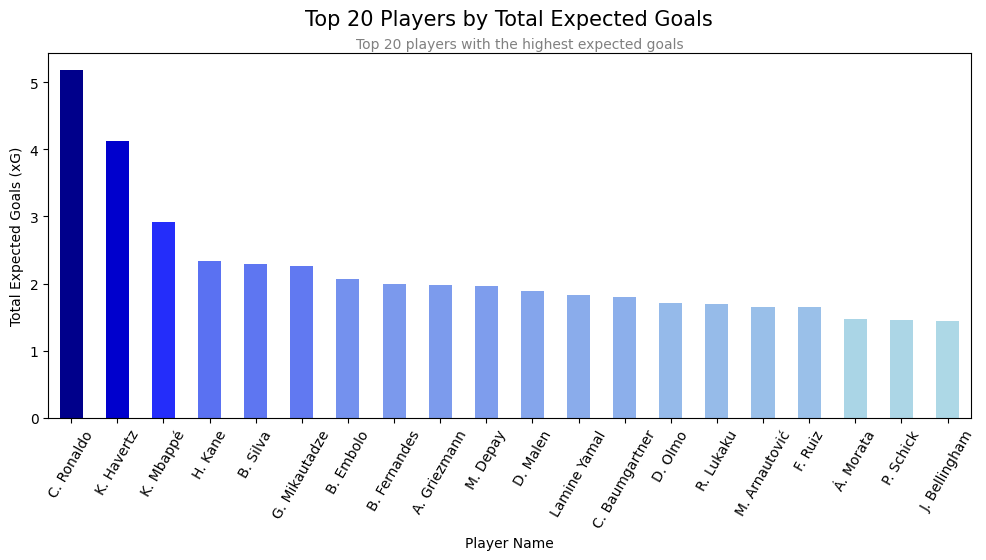

In [ ]:
norm = plt.Normalize(xg_by_player['xg'].min(), xg_by_player['xg'].max())

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_blue', 
    ['lightblue', 'blue', 'darkblue'], 
    N=256
)

colors = custom_cmap(norm(xg_by_player['xg']))

plt.figure(figsize=(10, 6))
xg_by_player['xg'].plot(kind='bar', color=colors)

plt.title('Top 20 Players by Total Expected Goals', pad=20, fontsize=15)
plt.suptitle('Top 20 players with the highest expected goals', color='gray', y=0.88, fontsize=10, x=0.525)
plt.xlabel('Player Name')
plt.ylabel('Total Expected Goals (xG)')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

In [ ]:
goals_by_player = df_goals.groupby('player.id')['shotType'].count()

In [ ]:
xg_by_player = new_df.groupby('player.id').agg({'xg': 'sum', 'player.shortName': 'first'})

combined_data = xg_by_player.merge(goals_by_player, on='player.id', how='left').sort_values(by='xg', ascending=False).head(20)
combined_data.rename(columns={'shotType': 'goal_count'}, inplace=True)
combined_data.set_index('player.shortName', inplace=True)

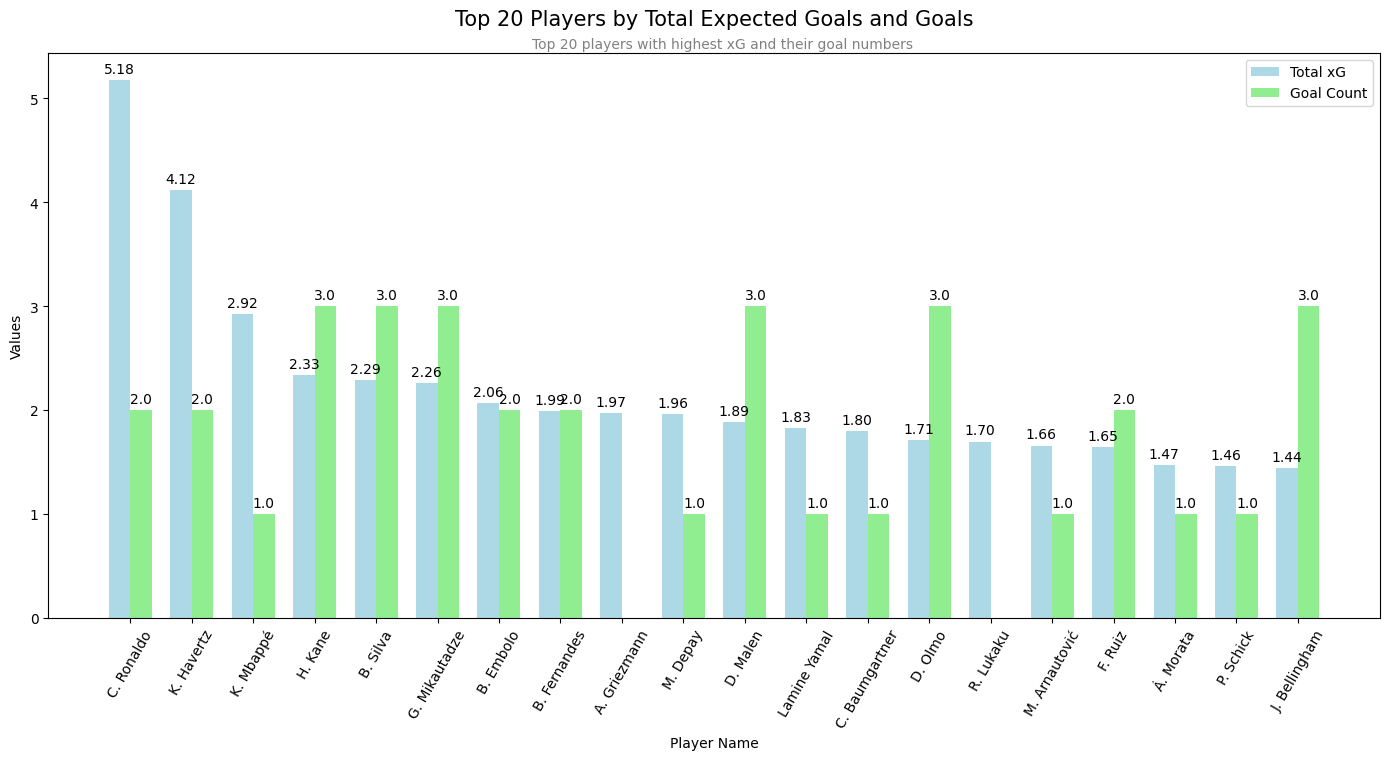

In [39]:
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35
indices = np.arange(len(combined_data))

xg_bars = ax.bar(indices - width/2, combined_data['xg'], width, label='Total xG', color='lightBlue')
goal_bars = ax.bar(indices + width/2, combined_data['goal_count'], width, label='Goal Count', color='lightGreen')

ax.set_xlabel('Player Name')
ax.set_ylabel('Values')
ax.set_title('Top 20 Players by Total Expected Goals and Goals',fontsize=15, pad=20)
fig.suptitle('Top 20 players with highest xG and their goal numbers', fontsize=10, color='gray', y=0.91, x=0.52)
ax.set_xticks(indices)
ax.set_xticklabels(combined_data.index, rotation=60)
ax.legend()

def add_labels(bars, decimals=None):
    for bar in bars:
        height = bar.get_height()
        label_format = f'{{:.{decimals}f}}' if decimals is not None else '{}'
        ax.annotate(label_format.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(xg_bars, 2)
add_labels(goal_bars)

plt.tight_layout()
plt.show()

In [40]:
top_5_players = xg_by_player.sort_values(by='xg', ascending=False).head(5)

In [41]:
top_5_shots = new_df[new_df['player.id'].isin(top_5_players.index)]

In [42]:
top_5_shots

player.name        player.slug player.shortName  \
shot_id                                                          
99       Cristiano Ronaldo  cristiano-ronaldo       C. Ronaldo   
103      Cristiano Ronaldo  cristiano-ronaldo       C. Ronaldo   
112      Cristiano Ronaldo  cristiano-ronaldo       C. Ronaldo   
196             Harry Kane         harry-kane          H. Kane   
197             Harry Kane         harry-kane          H. Kane   
...                    ...                ...              ...   
1291         Kylian Mbappé      kylian-mbappe        K. Mbappé   
1297         Kylian Mbappé      kylian-mbappe        K. Mbappé   
1298         Kylian Mbappé      kylian-mbappe        K. Mbappé   
1300         Kylian Mbappé      kylian-mbappe        K. Mbappé   
1309         Kylian Mbappé      kylian-mbappe        K. Mbappé   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
99                    F        750                 92.8                 45.8   
103                   F        750                 93.3                 64.9   
112                   F        750                 69.9                 47.1   
196                   F     108579                 93.5                 49.2   
197                   F     108579                 79.0                 52.6   
...                 ...        ...                  ...                  ...   
1291                  F     826643                 86.1                 39.9   
1297                  F     826643                 89.0                 43.2   
1298                  F     826643                 84.6                 65.7   
1300                  F     826643                 92.9                 69.1   
1309                  F     826643                 86.7                 63.8   

         isHome shotType  situation  ... draw.start.x draw.start.y  \
shot_id                              ...                             
99        False    block     corner  ...         54.2          7.2   
103       False    block   assisted  ...         35.1          6.7   
112       False     save  free-kick  ...         52.9         30.1   
196       False     goal    regular  ...         50.8          6.5   
197       False    block    regular  ...         47.4         21.0   
...         ...      ...        ...  ...          ...          ...   
1291       True     miss   assisted  ...         60.1         13.9   
1297       True     miss   assisted  ...         56.8         11.0   
1298       True     miss   assisted  ...         34.3         15.4   
1300       True    block     corner  ...         30.9          7.1   
1309       True     miss     corner  ...         36.2         13.3   

         draw.block.x  draw.block.y  draw.end.x  draw.end.y  draw.goal.x  \
shot_id                                                                    
99               52.2           4.9        47.9           0         47.9   
103              37.4           5.7        51.6           0         51.6   
112              50.0           2.3        50.1           0         50.1   
196               NaN           NaN        46.4           0         46.4   
197              47.7          17.0        48.7           0         48.7   
...               ...           ...         ...         ...          ...   
1291              NaN           NaN        56.8           0         56.8   
1297              NaN           NaN        22.2           0         22.2   
1298              NaN           NaN        52.4           0         52.4   
1300             33.7           5.8        46.9           0         46.9   
1309              NaN           NaN        60.0           0         60.0   

         draw.goal.y    xgot  goalType  
shot_id                                 
99              81.0     NaN       NaN  
103             83.3     NaN       NaN  
112             71.5  0.0402       NaN  
196       

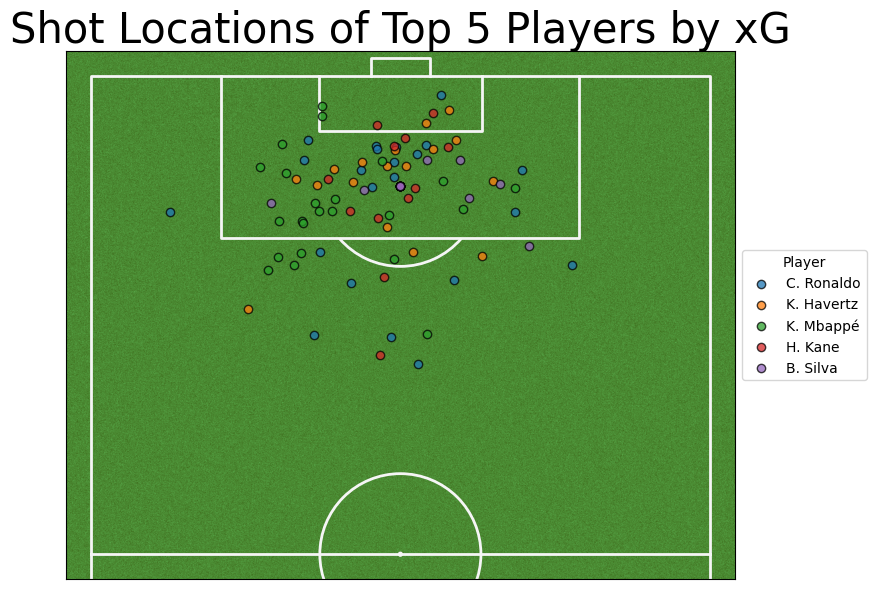

In [44]:
pitch = VerticalPitch(pitch_type='opta', pitch_color= 'grass', line_color='whitesmoke', goal_type='box',axis=True, half=True)
fig, ax = pitch.draw(figsize=(10,6))
ax.set_title('Shot Locations of Top 5 Players by xG', color='black', fontsize=30)

for player_id in top_5_players.index:
    player_shots = top_5_shots[top_5_shots['player.id'] == player_id]
    plt.scatter(player_shots['playerCoordinates.y'], player_shots['playerCoordinates.x'],
                label=top_5_players.loc[player_id, 'player.shortName'], edgecolors="black", alpha=0.75)
    
ax.legend(title='Player', loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
shots_by_player = new_df.groupby('player.id').size().sort_values(ascending=False).head(20)

In [ ]:
player_names = df.drop_duplicates(subset=['player.id']).set_index('player.id')['player.shortName']
top_20_shots = shots_by_player.head(20).index.map(player_names)

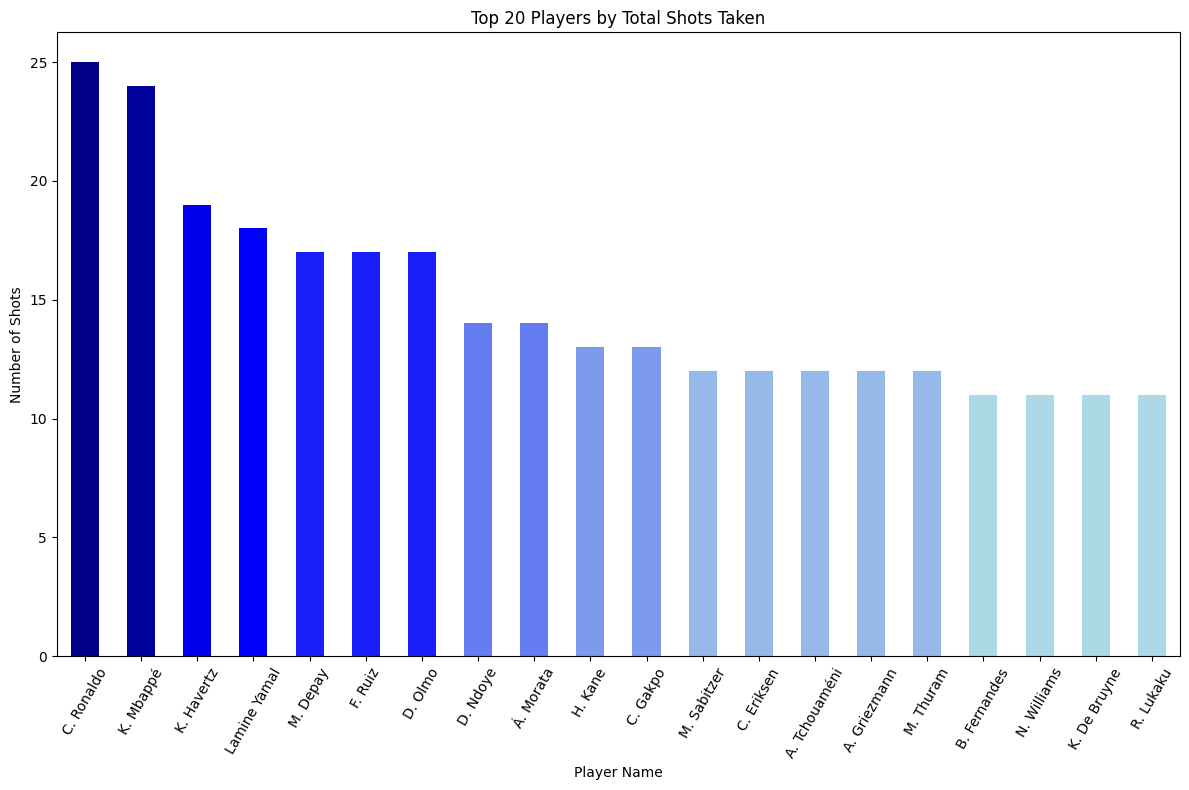

In [47]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_blue', 
    ['lightblue', 'blue', 'darkblue'], 
    N=256
)

norm = plt.Normalize(shots_by_player.head(20).min(), shots_by_player.head(20).max())

colors = custom_cmap(norm(shots_by_player.head(20).values))

plt.figure(figsize=(12, 8))
shots_by_player.head(20).plot(kind='bar', color=colors)
plt.title('Top 20 Players by Total Shots Taken')
plt.xlabel('Player Name')
plt.ylabel('Number of Shots')
plt.xticks(range(20), top_20_shots, rotation=60)
plt.tight_layout()
plt.show()

In [ ]:
player_stats = new_df.groupby('player.id').agg(total_xG=('xg', 'sum'),shot_count=('player.id', 'size'))

player_stats['xG_per_shot'] = player_stats['total_xG'] / player_stats['shot_count']

In [ ]:
filtered_player_stats = player_stats[player_stats['shot_count'] >= 3]

In [ ]:
top_effective_shooters = filtered_player_stats.sort_values(by='xG_per_shot', ascending=False).head(20)

In [ ]:
player_names = new_df.drop_duplicates(subset=['player.id']).set_index('player.id')['player.shortName']
top_effective_shooters['player_shortName'] = top_effective_shooters.index.map(player_names)

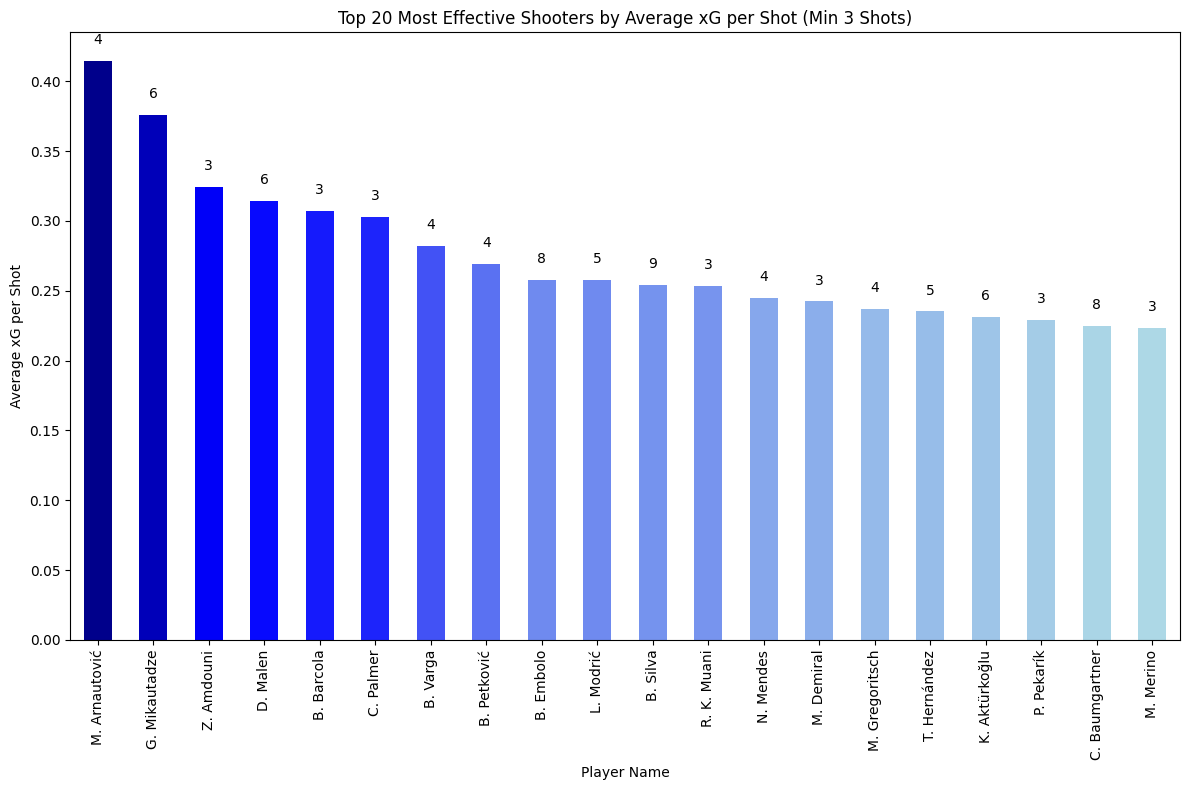

In [52]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_blue', 
    ['lightblue', 'blue', 'darkblue'], 
    N=256
)

norm = plt.Normalize(top_effective_shooters['xG_per_shot'].min(), top_effective_shooters['xG_per_shot'].max())

colors = custom_cmap(norm(top_effective_shooters['xG_per_shot'].values))


plt.figure(figsize=(12, 8))
bars = top_effective_shooters['xG_per_shot'].plot(kind='bar', color=colors)
plt.title('Top 20 Most Effective Shooters by Average xG per Shot (Min 3 Shots)')
plt.xlabel('Player Name')
plt.ylabel('Average xG per Shot')
plt.xticks(range(20), top_effective_shooters['player_shortName'], rotation=90)
plt.tight_layout()

for idx, bar in enumerate(bars.patches):
    shot_count = top_effective_shooters['shot_count'].iloc[idx]
    plt.annotate(f'{shot_count}',
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom',
                 textcoords="offset points",
                 xytext=(0, 10))

plt.show()

In [53]:
filtered_player_stats = player_stats[player_stats['shot_count'] >= 3]

In [54]:
least_effective_shooters = filtered_player_stats.sort_values(by='xG_per_shot', ascending=True).head(20)

In [55]:
least_effective_shooters['player_shortName'] = least_effective_shooters.index.map(player_names)

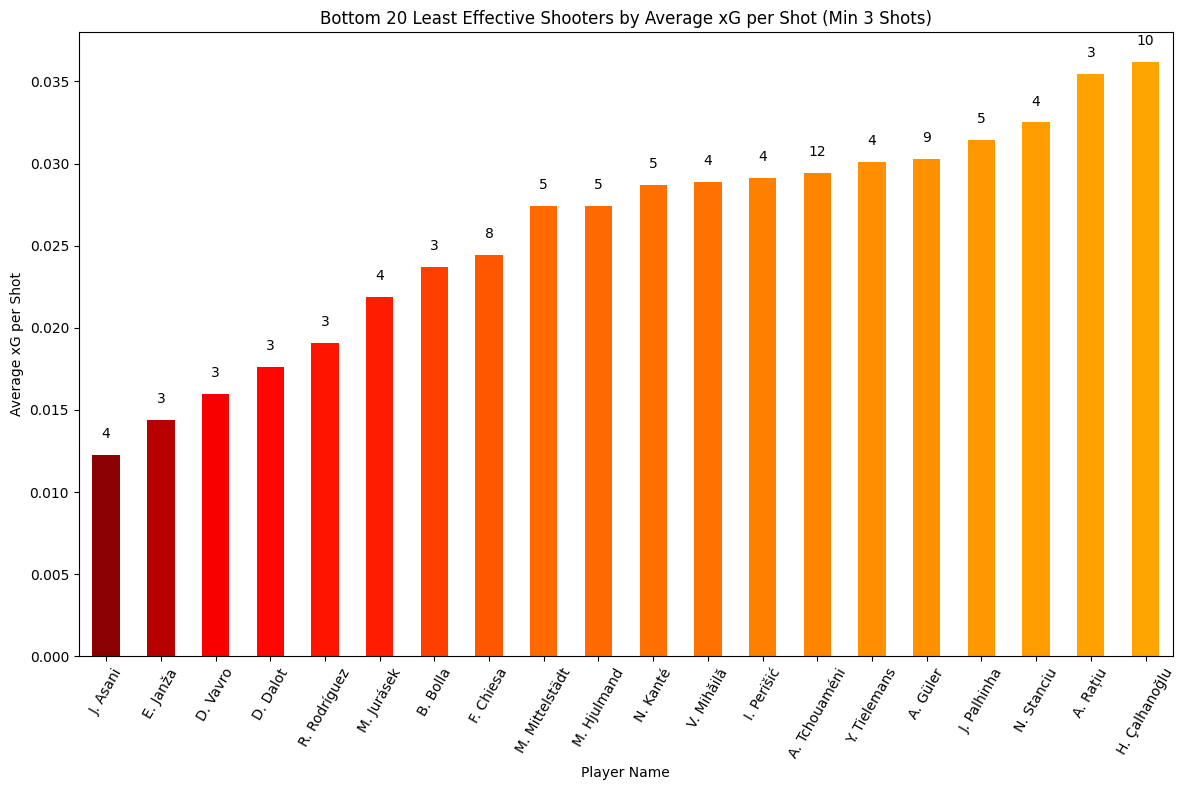

In [56]:
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_red', 
    ['orange', 'red', 'darkred'], 
    N=256
)

norm = plt.Normalize(top_effective_shooters['xG_per_shot'].min(), top_effective_shooters['xG_per_shot'].max())

colors = custom_cmap(norm(top_effective_shooters['xG_per_shot'].values))

plt.figure(figsize=(12, 8))
bars = least_effective_shooters['xG_per_shot'].plot(kind='bar', color=colors)
plt.title('Bottom 20 Least Effective Shooters by Average xG per Shot (Min 3 Shots)')
plt.xlabel('Player Name')
plt.ylabel('Average xG per Shot')
plt.xticks(range(20), least_effective_shooters['player_shortName'], rotation=60)
plt.tight_layout()

for idx, bar in enumerate(bars.patches):
    shot_count = least_effective_shooters['shot_count'].iloc[idx]
    plt.annotate(f'{shot_count}',
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='bottom',
                 textcoords="offset points",
                 xytext=(0, 10))  

plt.show()

In [ ]:
goal_stats = df_goals.groupby('player.id').agg(total_xG=('xg', 'sum'),goal_count=('player.id', 'size'))

goal_stats['xG_per_goal'] = goal_stats['total_xG'] / goal_stats['goal_count']

In [ ]:
filtered_goal_stats = goal_stats[goal_stats['goal_count'] >= 2]

In [ ]:
top_goalscorers = filtered_goal_stats.sort_values(by='xG_per_goal', ascending=False).head(15)

In [60]:
player_names = new_df.drop_duplicates(subset=['player.id']).set_index('player.id')['player.shortName']
top_goalscorers['player_shortName'] = top_goalscorers.index.map(player_names)

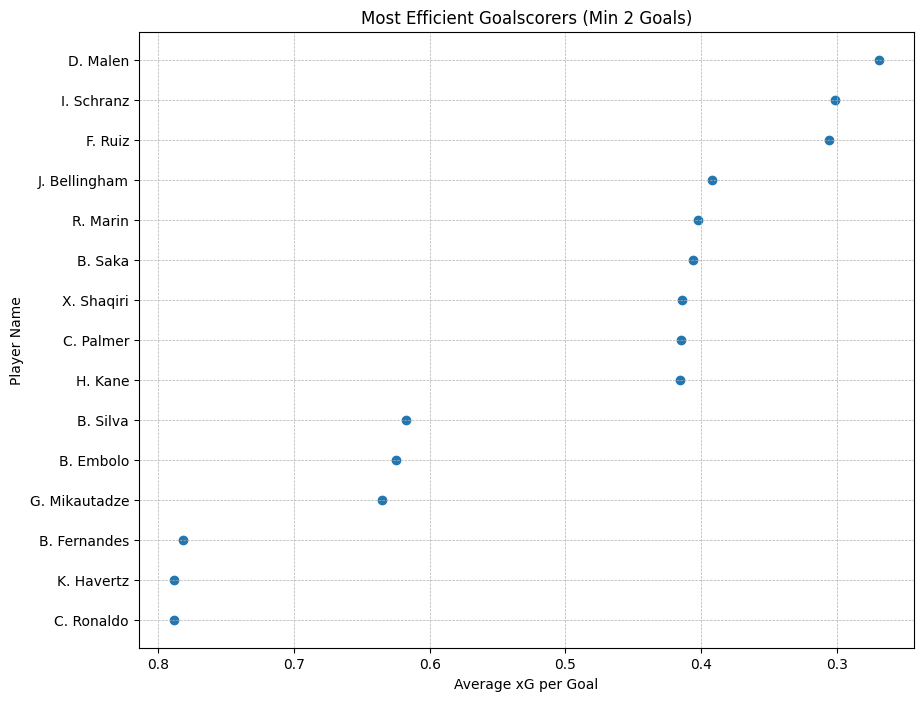

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(top_goalscorers['xG_per_goal'], top_goalscorers['player_shortName'])
ax.invert_xaxis()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_title('Most Efficient Goalscorers (Min 2 Goals)')
ax.set_xlabel('Average xG per Goal')
ax.set_ylabel('Player Name')

plt.show()

In [ ]:
biggest_misses = new_df.loc[(df['shotType'] == 'miss')].copy()
biggest_misses.sort_values(by='xg', ascending=False, inplace=True)
big_miss = biggest_misses.head(10)

In [63]:
big_miss

player.name            player.slug player.shortName  \
shot_id                                                                  
550          Antoine Griezmann      antoine-griezmann     A. Griezmann   
248              Peter Pekarík          peter-pekarik       P. Pekarík   
581          Cristiano Ronaldo      cristiano-ronaldo       C. Ronaldo   
553              Kylian Mbappé          kylian-mbappe        K. Mbappé   
430               Josip Šutalo           josip-sutalo        J. Šutalo   
88                  Diogo Jota             diogo-jota          D. Jota   
1104     Christoph Baumgartner  christoph-baumgartner   C. Baumgartner   
285                  Dani Olmo              dani-olmo          D. Olmo   
885              Donyell Malen          donyell-malen         D. Malen   
1083               Kai Havertz            kai-havertz       K. Havertz   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
550                   F      85859                 95.8                 48.7   
248                   D      36949                 96.7                 47.4   
581                   F        750                 91.8                 47.3   
553                   F     826643                 85.5                 51.9   
430                   D     954836                 98.8                 54.6   
88                    F     606164                 93.1                 50.3   
1104                  M     825956                 94.5                 53.2   
285                   M     789071                 90.7                 55.8   
885                   F     803039                 87.5                 58.7   
1083                  M     836705                 90.3                 60.7   

         isHome shotType   situation  ... draw.start.x draw.start.y  \
shot_id                               ...                             
550       False     miss    assisted  ...         51.3          4.2   
248       False     miss    assisted  ...         52.6          3.3   
581        True     miss    assisted  ...         52.7          8.2   
553       False     miss  fast-break  ...         48.1         14.5   
430        True     miss      corner  ...         45.4          1.2   
88        False     miss    assisted  ...         49.7          6.9   
1104       True     miss    assisted  ...         46.8          5.5   
285        True     miss    assisted  ...         44.2          9.3   
885        True     miss    assisted  ...         41.3         12.5   
1083       True     miss  fast-break  ...         39.3          9.7   

         draw.block.x  draw.block.y  draw.end.x  draw.end.y  draw.goal.x  \
shot_id                                                                    
550              81.6           1.2        79.8           0         79.8   
248               NaN           NaN        49.7           0         49.7   
581               NaN           NaN        56.5           0         56.5   
553               NaN           NaN        56.6           0         56.6   
430               NaN           NaN        41.8           0         41.8   
88                NaN           NaN        66.1           0         66.1   
1104              NaN           NaN        37.6           0         37.6   
285               NaN           NaN        59.4           0         59.4   
885               NaN           NaN        57.0           0         57.0   
1083              NaN           NaN        56.8           0         56.8   

         draw.goal.y  xgot  goalType  
shot_id                               
550             84.7   NaN       NaN  
248             45.8   NaN       NaN  
581             20.8   NaN       NaN  
553             81.9   NaN       NaN  
430             68.1   NaN       NaN  
88              90.3   NaN       NaN  
1104            54.2   NaN       NaN  
285             96.2   NaN       NaN  
885          

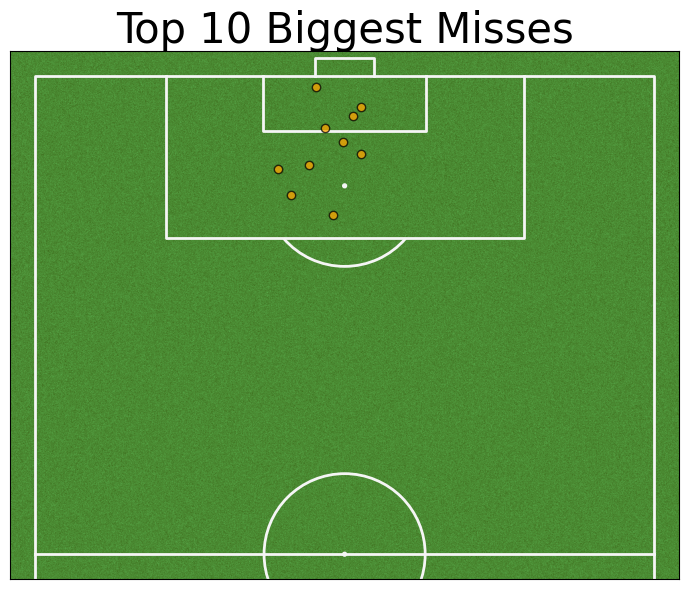

In [64]:
pitch = VerticalPitch(pitch_type="opta", pitch_color= "grass", line_color="whitesmoke", goal_type='box',axis=True, half=True)
fig, ax = pitch.draw(figsize=(10,6))
ax.set_title("Top 10 Biggest Misses", color="black", fontsize=30)

plt.scatter(big_miss["playerCoordinates.y"],big_miss["playerCoordinates.x"], edgecolors="black", alpha=0.75, c="orange")

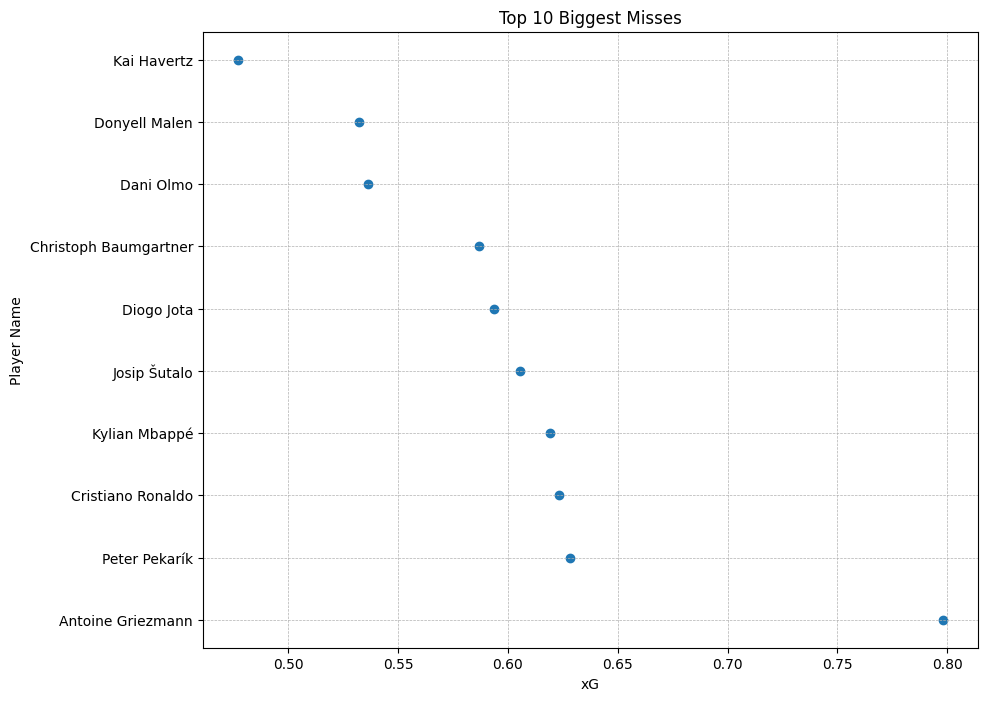

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(big_miss['xg'], big_miss['player.name'])
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_title('Top 10 Biggest Misses')
ax.set_xlabel('xG')
ax.set_ylabel('Player Name')

plt.show()

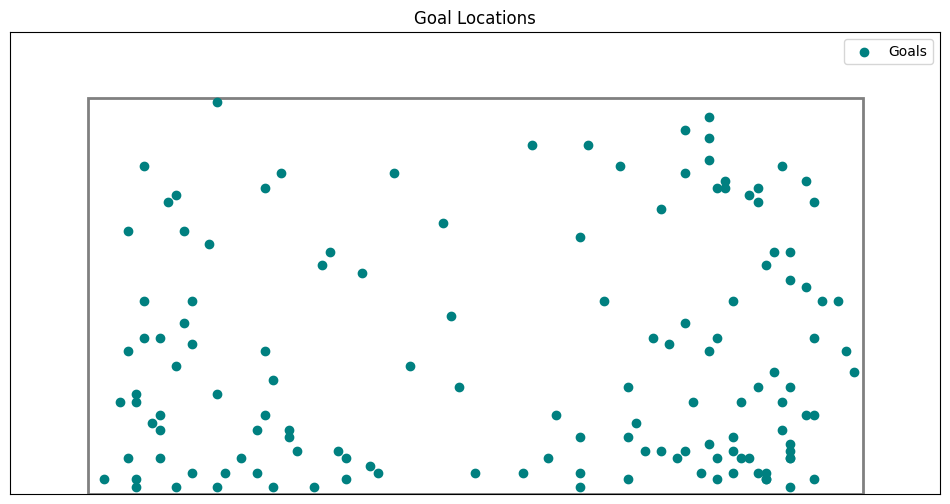

In [ ]:
goal_width = df_goals['goalMouthCoordinates.y'].max() - df_goals['goalMouthCoordinates.y'].min()
goal_height = df_goals['goalMouthCoordinates.z'].max() - df_goals['goalMouthCoordinates.z'].min()
goal_x_start = df_goals['goalMouthCoordinates.y'].min()
goal_y_start = 0

fig, ax = plt.subplots(figsize=(12, 6))

buffer = 0.2
goal_width += buffer * 1.5
goal_x_start -= buffer

goal = patches.Rectangle((goal_x_start, goal_y_start), goal_width, goal_height + 1, linewidth=2, edgecolor='gray', facecolor='none')
ax.add_patch(goal)

ax.scatter(df_goals['goalMouthCoordinates.y'], df_goals['goalMouthCoordinates.z'], color='teal', label='Goals')

pad_width = goal_width * 0.1
pad_height = goal_height * 0.2
ax.set_xlim(goal_x_start - pad_width, goal_x_start + goal_width + pad_width)
ax.set_ylim(0, goal_y_start + goal_height + pad_height)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Goal Locations')
ax.legend()


plt.show()

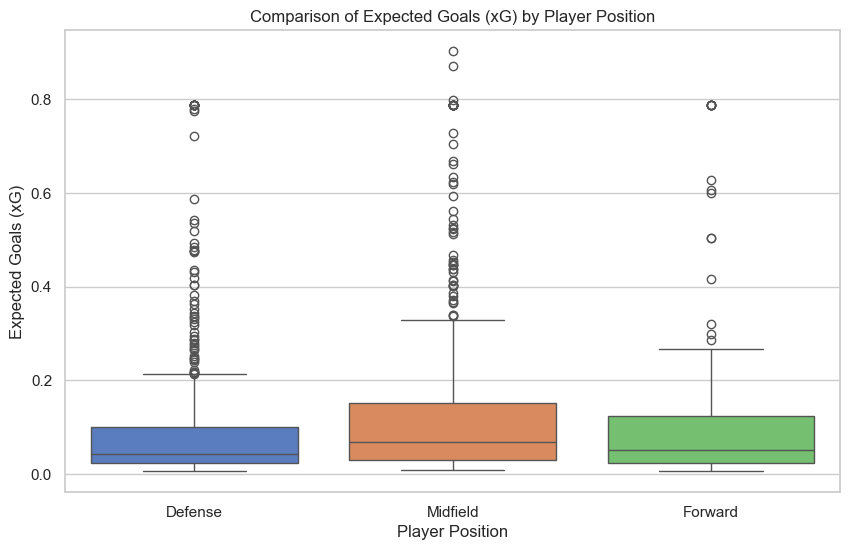

In [67]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='player.position', y='xg', data=new_df, hue='player.position', dodge=False, palette="muted")

ax.set_xlabel('Player Position')
ax.set_ylabel('Expected Goals (xG)')
ax.set_title('Comparison of Expected Goals (xG) by Player Position')
ax.set_xticklabels(['Defense', 'Midfield', 'Forward'])

plt.show()

In [ ]:
mean_xg = new_df.groupby('player.position')['xg'].mean()

In [ ]:
print(mean_xg.head())

player.position
D    0.109850
F    0.141632
M    0.094843
Name: xg, dtype: float64


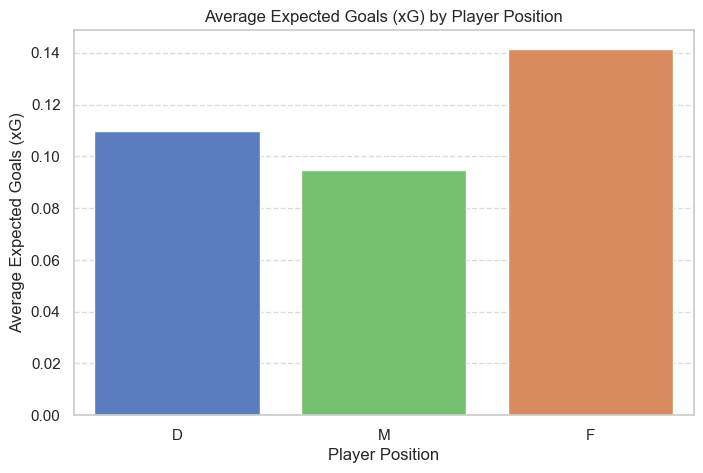

In [ ]:
mean_xg_df = mean_xg.reset_index()

position_order = ['D', 'M', 'F']

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='player.position', y='xg', data=mean_xg_df, order=position_order, palette='muted', hue='player.position')

ax.set_xlabel('Player Position')
ax.set_ylabel('Average Expected Goals (xG)')
ax.set_title('Average Expected Goals (xG) by Player Position')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

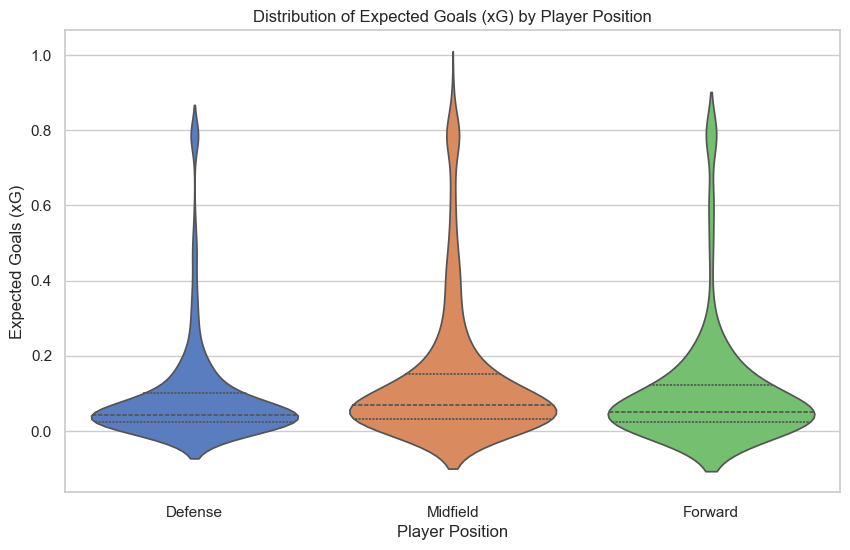

In [71]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='player.position', y='xg', data=new_df, palette="muted", inner="quartile", hue='player.position')

ax.set_xlabel('Player Position')
ax.set_ylabel('Expected Goals (xG)')
ax.set_title('Distribution of Expected Goals (xG) by Player Position')
ax.set_xticklabels(['Defense', 'Midfield', 'Forward'])

plt.show()

In [ ]:
shot_counts = new_df.groupby(['player.position', 'player.id', 'player.shortName']).size().reset_index(name='total_shots')

print(shot_counts.head())

  player.position  player.id player.shortName  total_shots
0               D       5884             Pepe            1
1               D      16921    J. Vertonghen            1
2               D      19352       M. Darmian            1
3               D      36949       P. Pekarík            3
4               D      67769     R. Rodríguez            3


In [ ]:
def top_n_players(group, n=5):
    return group.nlargest(n, 'total_shots')
top_players_by_position = shot_counts.groupby('player.position').apply(top_n_players, n=5, include_groups=False).reset_index(drop=False)

print(top_players_by_position)

   player.position  level_1  player.id player.shortName  total_shots
0                D       40     355486         S. Posch            7
1                D       10     101882         F. Schär            6
2                D       21     149734       A. Laporte            5
3                D       24     151545      V. van Dijk            5
4                D       46     788027     T. Hernández            5
5                F       91        750       C. Ronaldo           25
6                F      142     826643        K. Mbappé           24
7                F      182    1402912     Lamine Yamal           18
8                F      109     138833         M. Depay           17
9                F      106     125407        Á. Morata           14
10               M      271     836705       K. Havertz           19
11               M      253     784655          F. Ruiz           17
12               M      254     789071          D. Olmo           17
13               M      306     94

In [74]:
print(top_players_by_position.columns)

Index(['player.position', 'level_1', 'player.id', 'player.shortName',
       'total_shots'],
      dtype='object')


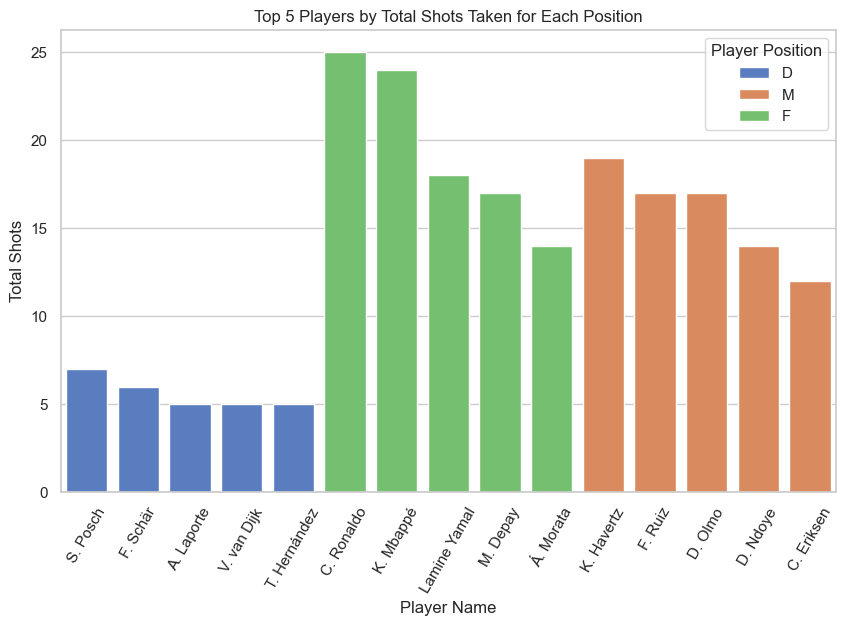

In [75]:
position_order = ['D', 'M', 'F']
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='player.shortName', y='total_shots', hue='player.position', data=top_players_by_position, palette='muted', hue_order=position_order)

plt.xlabel('Player Name')
plt.ylabel('Total Shots')
plt.title('Top 5 Players by Total Shots Taken for Each Position')
plt.xticks(rotation=60)

plt.legend(title='Player Position')
plt.show()

In [ ]:
xg_sums = df.groupby(['player.position', 'player.shortName'])['xg'].sum().reset_index()

top_xg_players_by_position = xg_sums.groupby('player.position').apply(lambda x: x.nlargest(5, 'xg'), include_groups=False).reset_index(drop=False)


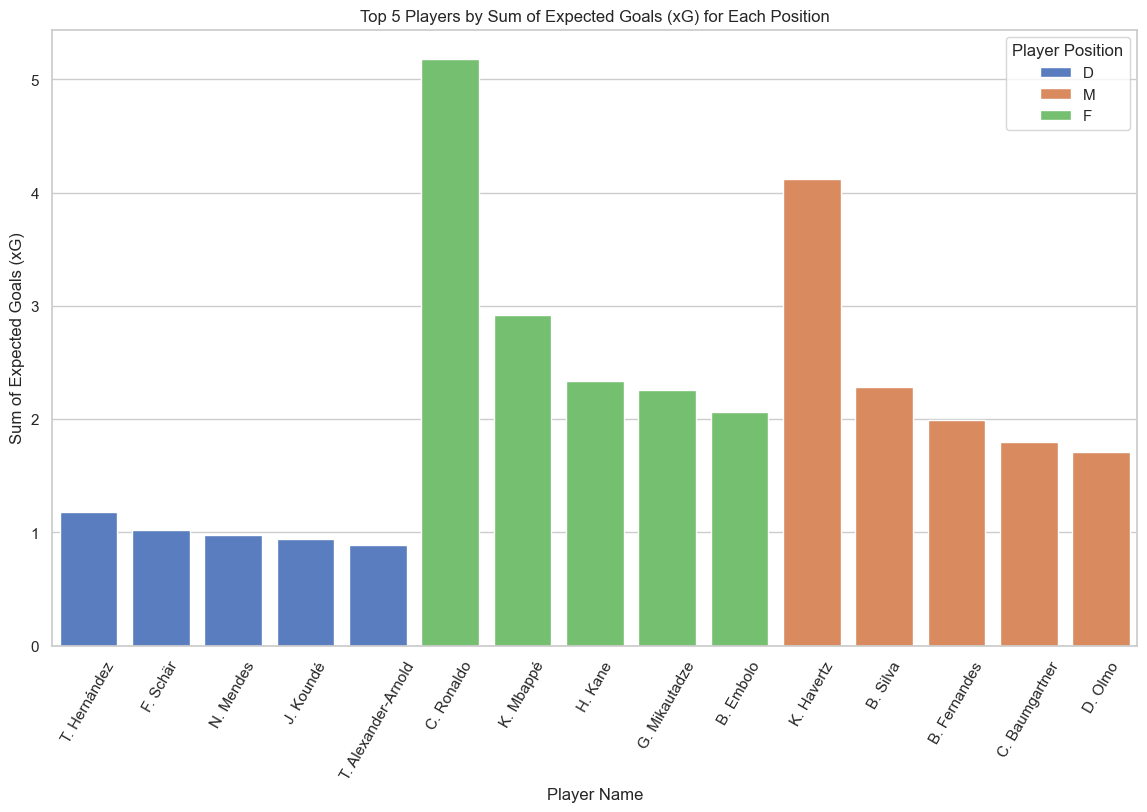

In [77]:
position_order = ['D', 'M', 'F']

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='player.shortName', y='xg', hue='player.position', data=top_xg_players_by_position, palette='muted', hue_order=position_order)

plt.xlabel('Player Name')
plt.ylabel('Sum of Expected Goals (xG)')
plt.title('Top 5 Players by Sum of Expected Goals (xG) for Each Position')
plt.xticks(rotation=60)

plt.legend(title='Player Position')
plt.show()


In [ ]:
df_non_penalty = df_goals[df_goals['goalType'] != 'penalty']

top_players = df_non_penalty.sort_values(by='xg', ascending=False).head(5)

bottom_players = df_non_penalty.sort_values(by='xg', ascending=True).head(5)

In [79]:
top_players

player.name          player.slug player.shortName  \
shot_id                                                              
491            Patrik Schick        patrik-schick        P. Schick   
953             Denis Drăguş         denis-dragus        D. Drăguş   
909         Kerem Aktürkoğlu     kerem-akturkoglu    K. Aktürkoğlu   
799          Bruno Fernandes      bruno-fernandes     B. Fernandes   
607      Francisco Conceição  francisco-conceicao     F. Conceição   

        player.position  player.id  playerCoordinates.x  playerCoordinates.y  \
shot_id                                                                        
491                   F     280609                 98.7                 52.6   
953                   F     841199                 96.3                 48.8   
909                   M     903324                 76.6                 35.0   
799                   M     288205                 92.3                 54.3   
607                   M     979222                 96.4                 52.6   

         isHome shotType   situation  ... draw.start.x draw.start.y  \
shot_id                               ...                             
491       False     goal      corner  ...         47.4          1.3   
953        True     goal      corner  ...         51.2          3.7   
909        True     goal  fast-break  ...         65.0         23.4   
799       False     goal    assisted  ...         45.7          7.7   
607        True     goal     regular  ...         47.4          3.6   

         draw.block.x  draw.block.y  draw.end.x  draw.end.y  draw.goal.x  \
shot_id                                                                    
491               NaN           NaN        47.3           0         47.3   
953               NaN           NaN        49.0           0         49.0   
909               NaN           NaN        47.5           0         47.5   
799               NaN           NaN        48.7           0         48.7   
607               NaN           NaN        46.8           0         46.8   

         draw.goal.y    xgot  goalType  
shot_id                                 
491             91.8  0.9804   regular  
953             93.0  0.8199   regular  
909             96.8  0.4793   regular  
799             98.1  0.6382   regular  
607             96.2  0.9736   regular  

[5 rows x 33 columns]

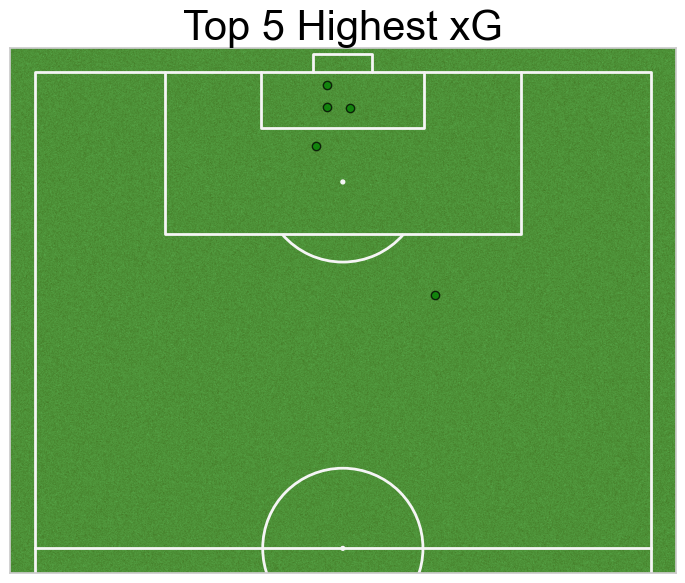

In [80]:
pitch = VerticalPitch(pitch_type="opta", pitch_color= "grass", line_color="whitesmoke", goal_type='box',axis=True, half=True)
fig, ax = pitch.draw(figsize=(10,6))
ax.set_title("Top 5 Highest xG", color="black", fontsize=30)

plt.scatter(top_players["playerCoordinates.y"],top_players["playerCoordinates.x"], edgecolors="black", alpha=0.75, c="green")

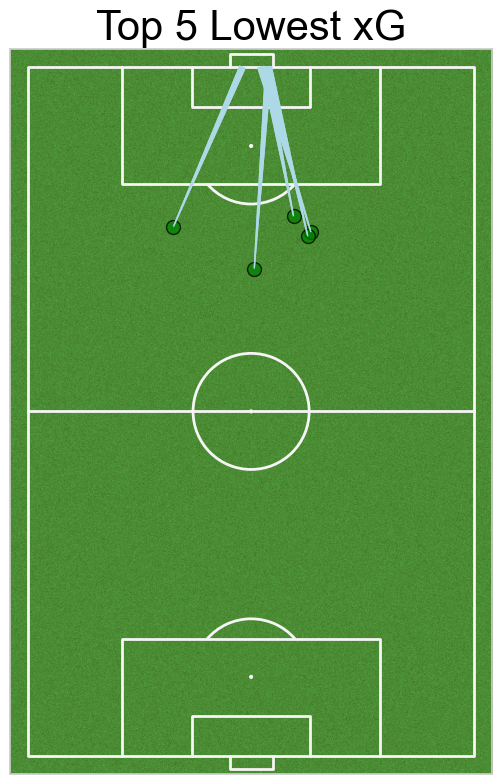

In [81]:
pitch = VerticalPitch(pitch_type="opta", pitch_color= "grass", line_color="whitesmoke", goal_type='box',axis=True, half=False)
fig, ax = pitch.draw(figsize=(12,8))
ax.set_title("Top 5 Lowest xG", color="black", fontsize=30)

plt.scatter(bottom_players["playerCoordinates.y"],bottom_players["playerCoordinates.x"], edgecolors="black", alpha=0.75, c="green", s= 100)
line = pitch.lines(100 - pd.to_numeric(bottom_players["draw.start.y"]), 100 - pd.to_numeric(bottom_players["draw.start.x"]), 100 + pd.to_numeric(bottom_players["draw.end.y"]), pd.to_numeric(bottom_players["draw.end.x"]),comet=True, color='lightBlue', ax=ax)

In [82]:
bottom_players

player.name      player.slug player.shortName player.position  \
shot_id                                                                      
771           Erik Janža       erik-janza         E. Janža               D   
190      Morten Hjulmand  hjulmand-morten      M. Hjulmand               M   
956         Răzvan Marin     razvan-marin         R. Marin               M   
962      Nicolae Stanciu  nicolae-stanciu       N. Stanciu               M   
760         Lamine Yamal     lamine-yamal     Lamine Yamal               F   

         player.id  playerCoordinates.x  playerCoordinates.y  isHome shotType  \
shot_id                                                                         
771         124590                 76.8                 67.4    True     goal   
190         859917                 70.7                 49.3    True     goal   
956         279563                 76.0                 36.6    True     goal   
962         108673                 78.3                 40.5    True     goal   
760        1402912                 75.4                 37.3    True     goal   

          situation  ... draw.start.x draw.start.y  draw.block.x  \
shot_id              ...                                           
771          corner  ...         32.6         23.2           NaN   
190        assisted  ...         50.7         29.3           NaN   
956      fast-break  ...         63.4         24.0           NaN   
962        assisted  ...         59.5         21.7           NaN   
760        assisted  ...         62.7         24.6           NaN   

         draw.block.y  draw.end.x  draw.end.y  draw.goal.x  draw.goal.y  \
shot_id                                                                   
771               NaN        51.9           0         51.9         79.7   
190               NaN        46.1           0         46.1         96.2   
956               NaN        47.9           0         47.9         96.2   
962               NaN        47.1           0         47.1         66.5   
760               NaN        46.1           0         46.1         81.0   

           xgot  goalType  
shot_id                    
771      0.0978   regular  
190      0.3113   regular  
956      0.1323   regular  
962      0.4118   regular  
760      0.3761   regular  

[5 rows x 33 columns]

In [ ]:
midfield_shots = df_goals[df_goals['player.position'] == 'M']

In [ ]:
total_shots = len(midfield_shots)
goals_scored = midfield_shots[midfield_shots['goalType'] == 'Goal'].count()
total_xG = midfield_shots['xg'].sum()

print(f"Total Shots by Midfielders: {total_shots}")
print(f"Total Expected Goals (xG): {total_xG:.2f}")


Total Shots by Midfielders: 57
Total Expected Goals (xG): 17.62


In [ ]:
shooting_accuracy = goals_scored / total_shots
conversion_rate = goals_scored / total_xG

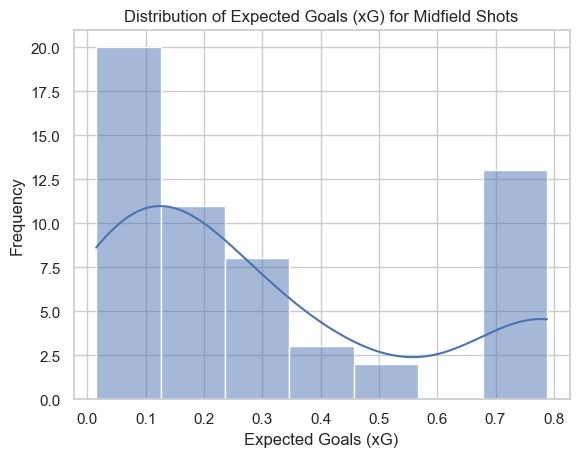

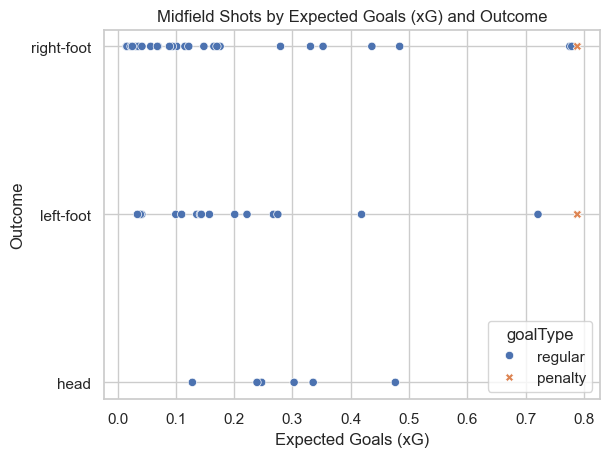

In [86]:
sns.histplot(midfield_shots['xg'], kde=True)
plt.title('Distribution of Expected Goals (xG) for Midfield Shots')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Frequency')
plt.show()

sns.scatterplot(x='xg', y='bodyPart', data=midfield_shots, hue='goalType', style='goalType', markers=True)
plt.title('Midfield Shots by Expected Goals (xG) and Outcome')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Outcome')
plt.show()

In [ ]:
df_goals.loc[:, 'time'] = pd.to_numeric(df_goals['time'], errors='coerce')
df_goals.loc[:, 'addedTime'] = pd.to_numeric(df_goals['addedTime'], errors='coerce').fillna(0)

df_goals.loc[:, 'total_time'] = df_goals['time'] + df_goals['addedTime']

print(df_goals[['time', 'addedTime', 'total_time']].head())

         time  addedTime  total_time
shot_id                             
22          7        0.0         7.0
30         83        0.0        83.0
45         29        0.0        29.0
52         16        0.0        16.0
74         46        0.0        46.0


/var/folders/fp/5_bj1cjn7s1851d6x2k9fz8m0000gn/T/ipykernel_5282/4202252527.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goals.loc[:, 'total_time'] = df_goals['time'] + df_goals['addedTime']


In [ ]:
def categorize_time(time):
    if time >= 90:
        return '90+ mins'
    interval = int(time / 15) * 15
    return f'{interval}-{interval + 14} mins'

df_goals.loc[:,'time_interval'] = df_goals.loc[:,'total_time'].apply(categorize_time)

/var/folders/fp/5_bj1cjn7s1851d6x2k9fz8m0000gn/T/ipykernel_5282/3980397979.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goals.loc[:,'time_interval'] = df_goals.loc[:,'total_time'].apply(categorize_time)


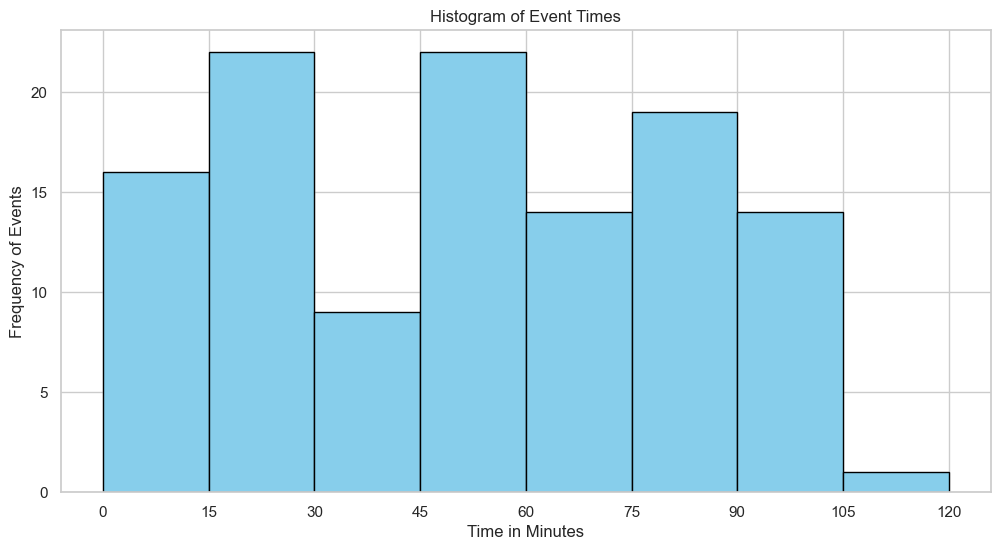

In [89]:
plt.figure(figsize=(12, 6))
plt.hist(df_goals['total_time'], bins=range(0, 121, 15), color='skyblue', edgecolor='black')
plt.title('Histogram of Event Times')
plt.xlabel('Time in Minutes')
plt.ylabel('Frequency of Events')
plt.xticks(range(0, 121, 15))
plt.show()

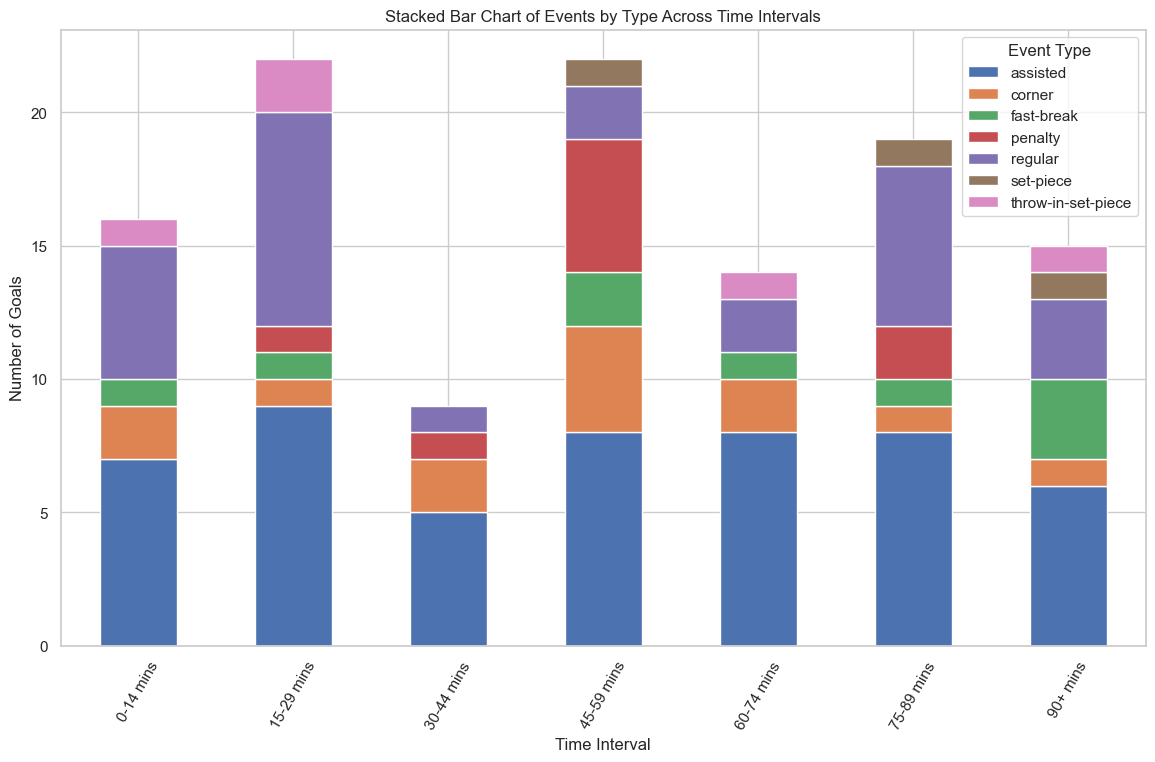

In [ ]:
event_types = df_goals[df_goals['situation'] != 'shootout'].groupby(['time_interval', 'situation']).size().unstack(fill_value=0)

event_types.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Stacked Bar Chart of Events by Type Across Time Intervals')
plt.xlabel('Time Interval')
plt.ylabel('Number of Goals')
plt.xticks(rotation=60)
plt.legend(title='Event Type')
plt.show()

In [95]:
new_df.loc[:,'playerCoordinates.x'] = pd.to_numeric(df['playerCoordinates.x'], errors='coerce')

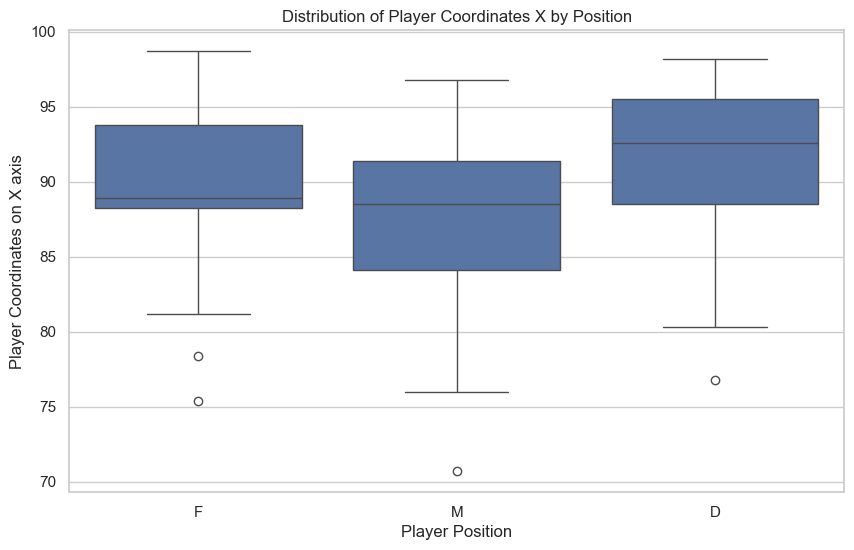

In [96]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='player.position', y='playerCoordinates.x', data=df_goals)

ax.set_title('Distribution of Player Coordinates X by Position')
ax.set_xlabel('Player Position')
ax.set_ylabel('Player Coordinates on X axis')

plt.show()

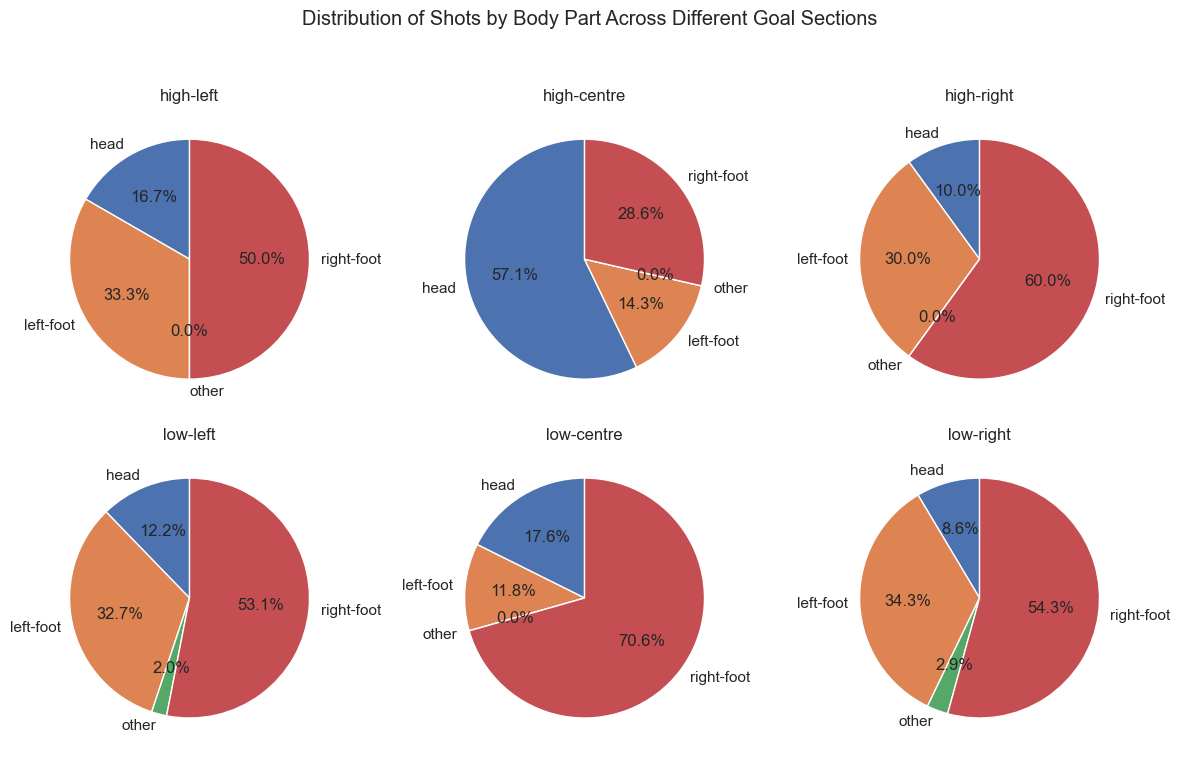

In [ ]:
location_bodypart = df_goals.groupby(['goalMouthLocation', 'bodyPart']).size().unstack(fill_value=0)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()
sections = ['high-left', 'high-centre', 'high-right', 'low-left', 'low-centre', 'low-right']

for ax, section in zip(axes, sections):
    data = location_bodypart.loc[section] if section in location_bodypart.index else pd.Series()
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(section)

plt.suptitle('Distribution of Shots by Body Part Across Different Goal Sections')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

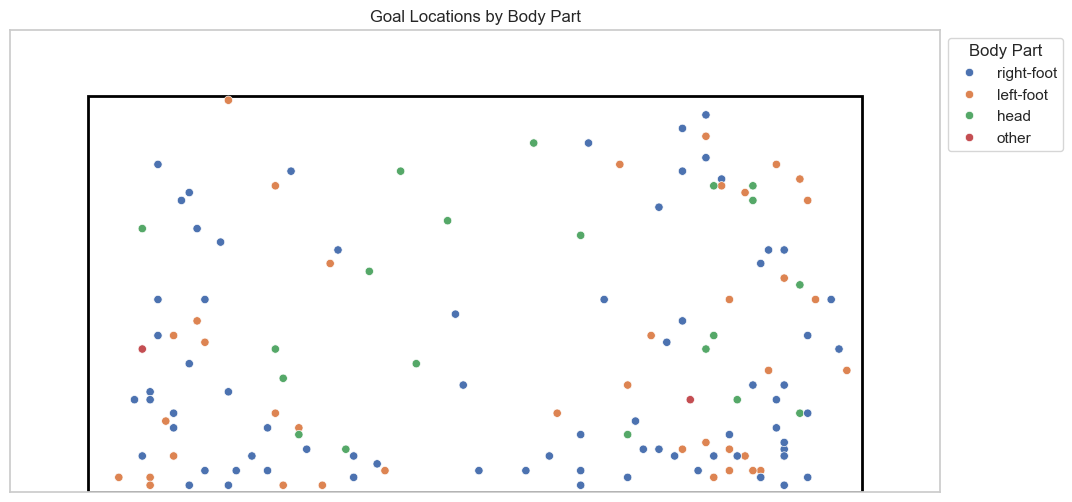

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

buffer = 0.2
goal_width += buffer * 1.5
goal_x_start -= buffer

goal = Rectangle((goal_x_start, goal_y_start), goal_width, goal_height + 1, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(goal)

sns.scatterplot(data=df_goals, x='goalMouthCoordinates.y', y='goalMouthCoordinates.z', hue='bodyPart', palette='deep', legend='full')

pad_width = goal_width * 0.1
pad_height = goal_height * 0.2
ax.set_xlim(goal_x_start - pad_width, goal_x_start + goal_width + pad_width)
ax.set_ylim(0, goal_y_start + goal_height + pad_height)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_title('Goal Locations by Body Part')
ax.legend(title='Body Part', bbox_to_anchor = (1,1))

plt.show()

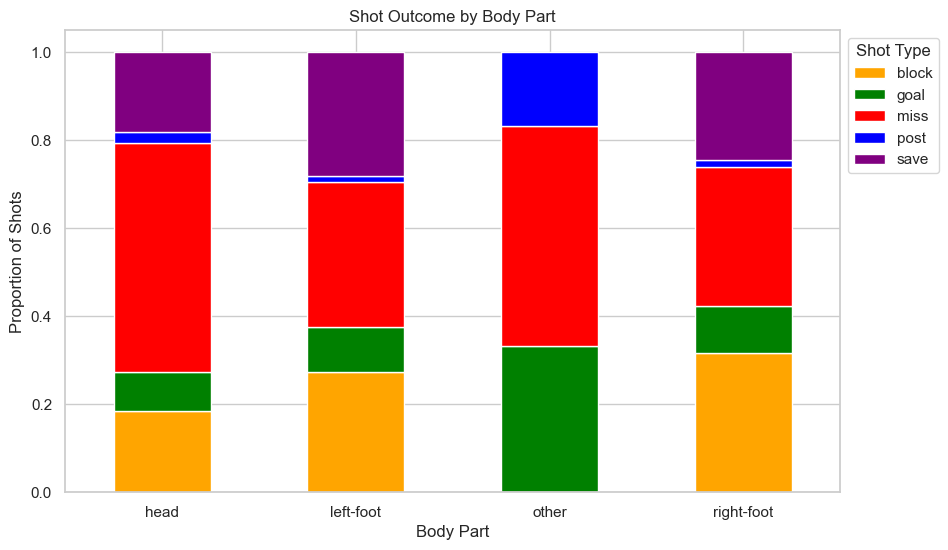

In [ ]:
ct = pd.crosstab(df['bodyPart'], df['shotType'])

ct = ct.div(ct.sum(axis=1), axis=0)

ct.plot(kind='bar', stacked=True, color=['orange', 'green', 'red', 'blue', 'purple'], figsize=(10, 6))
plt.title('Shot Outcome by Body Part')
plt.xlabel('Body Part')
plt.ylabel('Proportion of Shots')
plt.legend(title='Shot Type', bbox_to_anchor = (1,1))
plt.xticks(rotation=0)
plt.show()

In [ ]:
new_df = df.copy()

new_df.loc[:, 'time'] = pd.to_numeric(new_df['time'], errors='coerce')
new_df.loc[:, 'addedTime'] = pd.to_numeric(new_df['addedTime'], errors='coerce').fillna(0)

new_df.loc[:, 'total_time'] = new_df['time'] + new_df['addedTime']

print(new_df[['time', 'addedTime', 'total_time']].head())

   time  addedTime  total_time
0    90        3.0        93.0
1    90        1.0        91.0
2    80        0.0        80.0
3    80        0.0        80.0
4    78        0.0        78.0


In [106]:
def categorize_time(time):
    if time >= 90:
        return '90+ mins'
    interval = int(time / 15) * 15
    return f'{interval}-{interval + 14} mins'

new_df.loc[:,'time_interval'] = new_df.loc[:,'total_time'].apply(categorize_time)

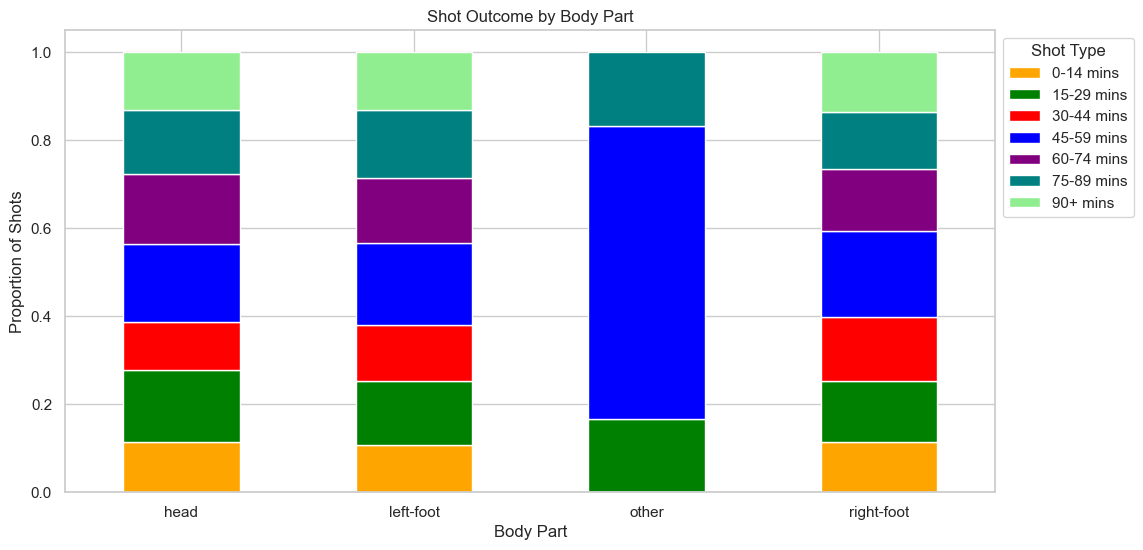

In [107]:
ct = pd.crosstab(df['bodyPart'], new_df['time_interval'])

ct = ct.div(ct.sum(axis=1), axis=0)

ct.plot(kind='bar', stacked=True, color=['orange', 'green', 'red', 'blue', 'purple', 'teal', 'lightGreen'], figsize=(12, 6))
plt.title('Shot Outcome by Body Part')
plt.xlabel('Body Part')
plt.ylabel('Proportion of Shots')
plt.legend(title='Shot Type', bbox_to_anchor = (1,1))
plt.xticks(rotation=0)
plt.show()

In [ ]:
new_df.loc[:,'is_goal'] = (new_df.loc[:,'shotType'] == 'goal').astype(int)

summary = new_df.groupby('bodyPart').agg(
    total_shots=('is_goal', 'count'),
    goals=('is_goal', 'sum')
).reset_index()

summary['success_rate'] = summary['goals'] / summary['total_shots']

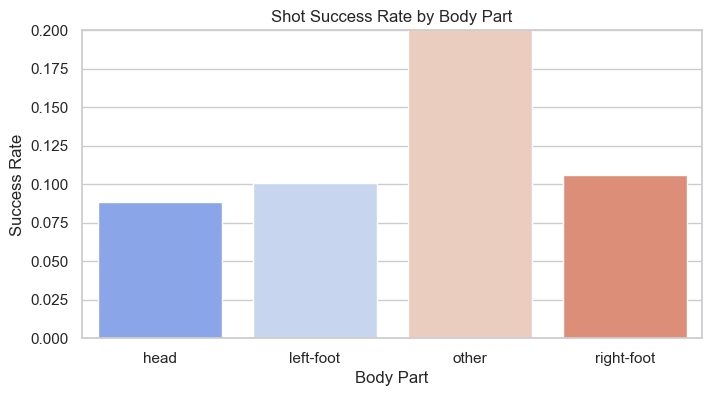

In [109]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
sns.barplot(x='bodyPart', y='success_rate', data=summary, palette='coolwarm', hue='bodyPart')
plt.title('Shot Success Rate by Body Part')
plt.xlabel('Body Part')
plt.ylabel('Success Rate')
plt.ylim(0, 0.2)
plt.show()

In [ ]:
saved_df = new_df[(new_df['xgot'].notna()) & (new_df['shotType'] == 'save')]

saved_df.head()

isHome shotType situation    bodyPart goalMouthLocation        xg  \
10    True     save  assisted  right-foot         low-right  0.048303   
11    True     save  assisted  right-foot         low-right  0.061577   
15   False     save  assisted  right-foot        high-right  0.094665   
16    True     save    corner        head        low-centre  0.072063   
18   False     save  assisted  right-foot        low-centre  0.067364   

         id  time  addedTime  timeSeconds  ...  draw.goal.x  draw.goal.y  \
10  3358247    59        0.0         3500  ...         52.8         92.4   
11  3358244    55        0.0         3295  ...         53.8         81.0   
15  3357857    40        0.0         2358  ...         54.2         74.1   
16  3357853    36        0.0         2115  ...         50.0         80.4   
18  3357851    31        0.0         1836  ...         50.7         98.7   

   player.firstName player.lastName    xgot goalType shootoutOrder total_time  \
10                                   0.1168      NaN           NaN       59.0   
11              NaN             NaN  0.1802      NaN           NaN       55.0   
15                                   0.5514      NaN           NaN       40.0   
16              NaN             NaN  0.0220      NaN           NaN       36.0   
18              NaN             NaN  0.0427      NaN           NaN       31.0   

    time_interval  is_goal  
10     45-59 mins        0  
11     45-59 mins        0  
15     30-44 mins        0  
16     30-44 mins        0  
18     30-44 mins        0  

[5 rows x 47 columns]

In [111]:
saved_df.loc[:, "playerCoordinates.x"] = 100 - saved_df["playerCoordinates.x"]
saved_df.loc[:, "playerCoordinates.y"] = 100 - saved_df["playerCoordinates.y"]

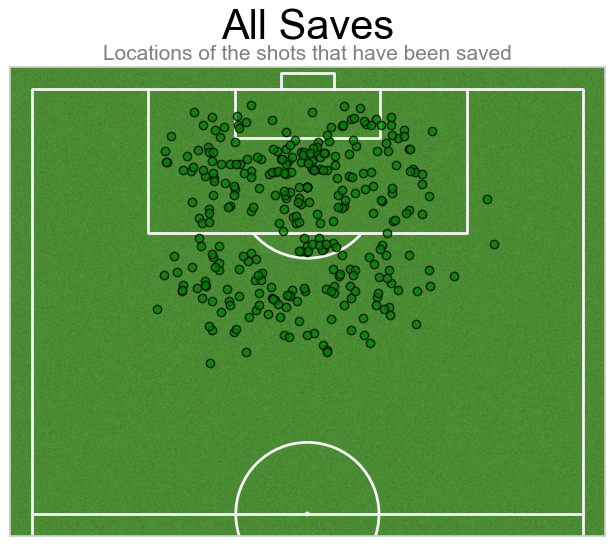

In [131]:
pitch = VerticalPitch(pitch_type="opta", pitch_color="grass", line_color="whitesmoke", goal_type="box", axis=True, half=True)
fig, ax = pitch.draw(figsize=(10, 6))

ax.set_title("All Saves", color="black", fontsize=30, pad=20)
fig.suptitle('Locations of the shots that have been saved', fontsize=15, color='gray', y=0.85)

plt.scatter(saved_df["playerCoordinates.y"], saved_df["playerCoordinates.x"], edgecolors="black", alpha=0.75, c="green")

plt.show()


In [142]:
filtered_df = saved_df[(saved_df['situation'] != 'shootout') & (saved_df['situation'] != 'penalty')]

In [ ]:
top_saves = filtered_df.sort_values(by='xgot', ascending=False).head(10)

In [144]:
top_saves

isHome shotType   situation    bodyPart goalMouthLocation        xg  \
1132   False     save    assisted   left-foot         low-right  0.728096   
676     True     save    assisted  right-foot        high-right  0.366498   
778    False     save  fast-break  right-foot        low-centre  0.402824   
557     True     save    assisted  right-foot          low-left  0.492988   
153    False     save    assisted        head       high-centre  0.448974   
1074    True     save  fast-break   left-foot         low-right  0.294960   
1201    True     save  fast-break  right-foot          low-left  0.150173   
157     True     save  fast-break   left-foot          low-left  0.321342   
1040    True     save    assisted   left-foot        low-centre  0.446315   
625     True     save    assisted   left-foot        low-centre  0.561529   

           id  time  addedTime  timeSeconds  ...  draw.goal.x  draw.goal.y  \
1132  3385300    65        0.0         3885  ...         53.3         94.9   
676   3422400    70        0.0         4160  ...         54.2         77.2   
778   3354046    65        0.0         3847  ...         48.4         86.7   
557   3358524    36        0.0         2107  ...         46.8         94.9   
153   3350711    55        0.0         3272  ...         49.7         75.3   
1074  3405930    90        5.0         5644  ...         52.9         99.4   
1201  3387361    89        0.0         5310  ...         47.1         97.5   
157   3350706    52        0.0         3105  ...         47.7         96.8   
1040  3409903    80        0.0         4797  ...         50.3         91.8   
625   3376814    32        0.0         1873  ...         51.3         95.6   

     player.firstName player.lastName    xgot goalType shootoutOrder  \
1132                                   0.9745      NaN           NaN   
676                                    0.9564      NaN           NaN   
778               NaN             NaN  0.9362      NaN           NaN   
557               NaN             NaN  0.9161      NaN           NaN   
153               NaN             NaN  0.8995      NaN           NaN   
1074              NaN             NaN  0.8842      NaN           NaN   
1201              NaN             NaN  0.8708      NaN           NaN   
157      Lamine Yamal             NaN  0.8362      NaN           NaN   
1040     Lamine Yamal             NaN  0.7830      NaN           NaN   
625               NaN             NaN  0.7707      NaN           NaN   

     total_time  time_interval  is_goal  
1132       65.0     60-74 mins        0  
676        70.0     60-74 mins        0  
778        65.0     60-74 mins        0  
557        36.0     30-44 mins        0  
153        55.0     45-59 mins        0  
1074       95.0       90+ mins        0  
1201       89.0     75-89 mins        0  
157        52.0     45-59 mins        0  
1040       80.0     75-89 mins        0  
625        32.0     30-44 mins        0  

[10 rows x 47 columns]

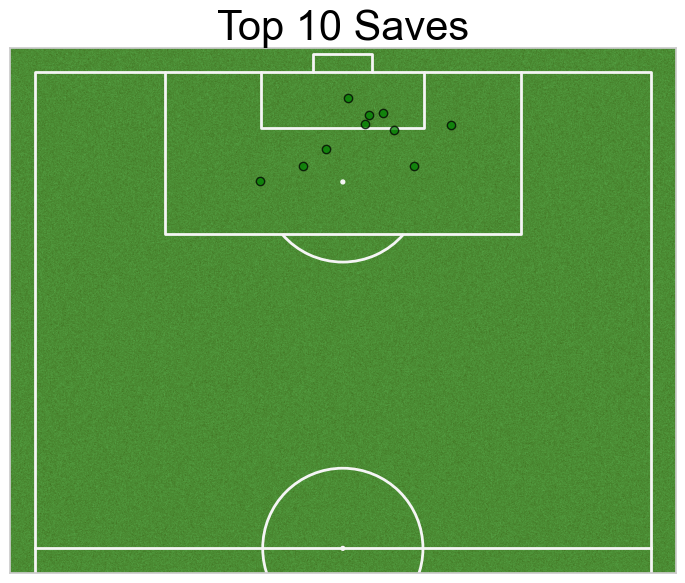

In [145]:
pitch = VerticalPitch(pitch_type="opta", pitch_color= "grass", line_color="whitesmoke", goal_type='box',axis=True, half=True)
fig, ax = pitch.draw(figsize=(10,6))
ax.set_title("Top 10 Saves", color="black", fontsize=30)

plt.scatter(top_saves["playerCoordinates.y"],top_saves["playerCoordinates.x"], edgecolors="black", alpha=0.75, c="green")


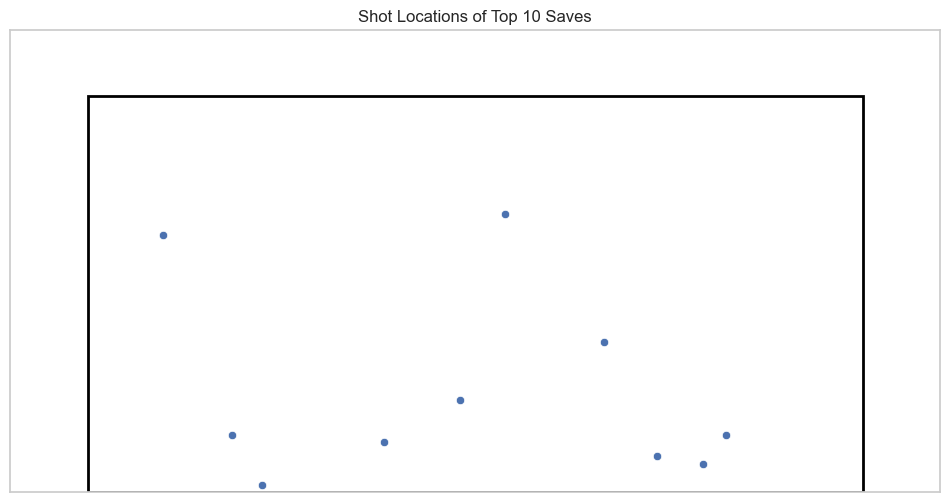

In [146]:
fig, ax = plt.subplots(figsize=(12, 6))

buffer = 0.2
goal_width += buffer * 1.5
goal_x_start -= buffer

goal = Rectangle((goal_x_start, goal_y_start), goal_width, goal_height + 1, linewidth=2, edgecolor='black', facecolor='none')
ax.add_patch(goal)

sns.scatterplot(data=top_saves, x='goalMouthCoordinates.y', y='goalMouthCoordinates.z', palette='deep')

pad_width = goal_width * 0.1
pad_height = goal_height * 0.2
ax.set_xlim(goal_x_start - pad_width, goal_x_start + goal_width + pad_width)
ax.set_ylim(0, goal_y_start + goal_height + pad_height)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_title('Shot Locations of Top 10 Saves')

plt.show()

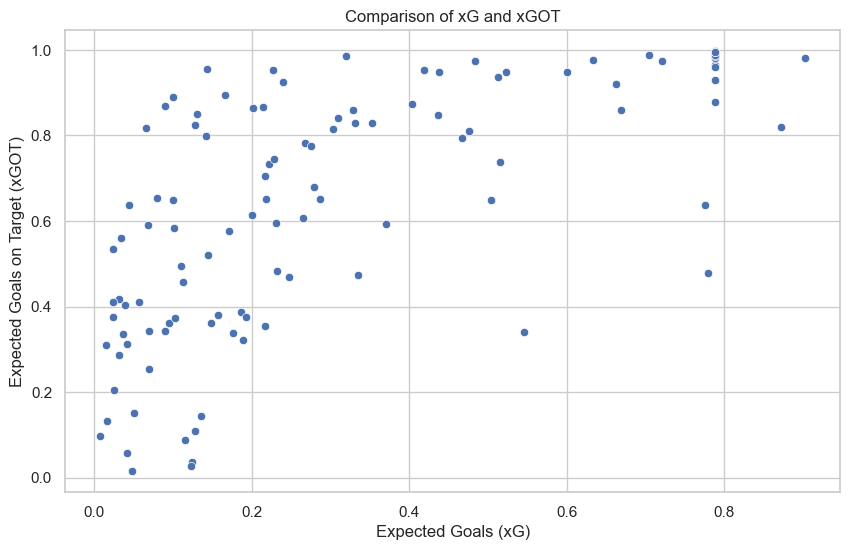

In [147]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='xg', y='xgot', data=df_goals)
plt.title('Comparison of xG and xGOT')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Expected Goals on Target (xGOT)')
plt.grid(True)
plt.show()

In [ ]:
# To get rid of copy warning
new_df = new_df.copy()
new_df.loc[:, 'mean_xG_xGOT'] = new_df[['xg', 'xgot']].mean(axis=1)
new_df.loc[:, 'diff_xG_xGOT'] = new_df['xg'] - new_df['xgot']

# Check for any necessary cleaning if NaN values exist
#new_df.dropna(subset=['mean_xG_xGOT', 'diff_xG_xGOT'], inplace=True)


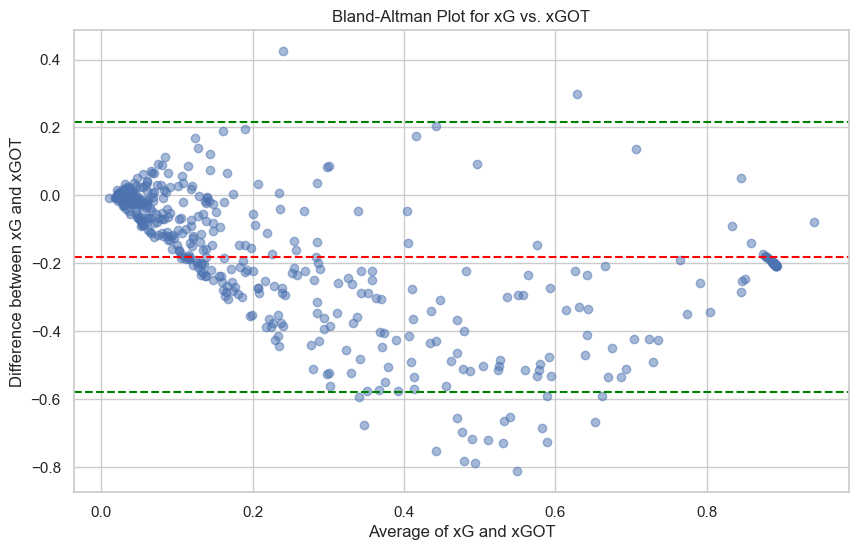

In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(new_df['mean_xG_xGOT'], new_df['diff_xG_xGOT'], alpha=0.5)
plt.axhline(y=new_df['diff_xG_xGOT'].mean(), color='red', linestyle='--')
plt.axhline(y=new_df['diff_xG_xGOT'].mean() + 1.96 * new_df['diff_xG_xGOT'].std(), color='green', linestyle='--')
plt.axhline(y=new_df['diff_xG_xGOT'].mean() - 1.96 * new_df['diff_xG_xGOT'].std(), color='green', linestyle='--')

plt.title('Bland-Altman Plot for xG vs. xGOT')
plt.xlabel('Average of xG and xGOT')
plt.ylabel('Difference between xG and xGOT')

plt.show()

In [ ]:
df['is_goal'] = (new_df['shotType'] == 'goal').astype(int)

conversion_summary = df.groupby('situation').agg(
    total_shots=('situation', 'count'),
    goals=('is_goal', 'sum')
).reset_index()

conversion_summary['conversion_rate'] = conversion_summary['goals'] / conversion_summary['total_shots']

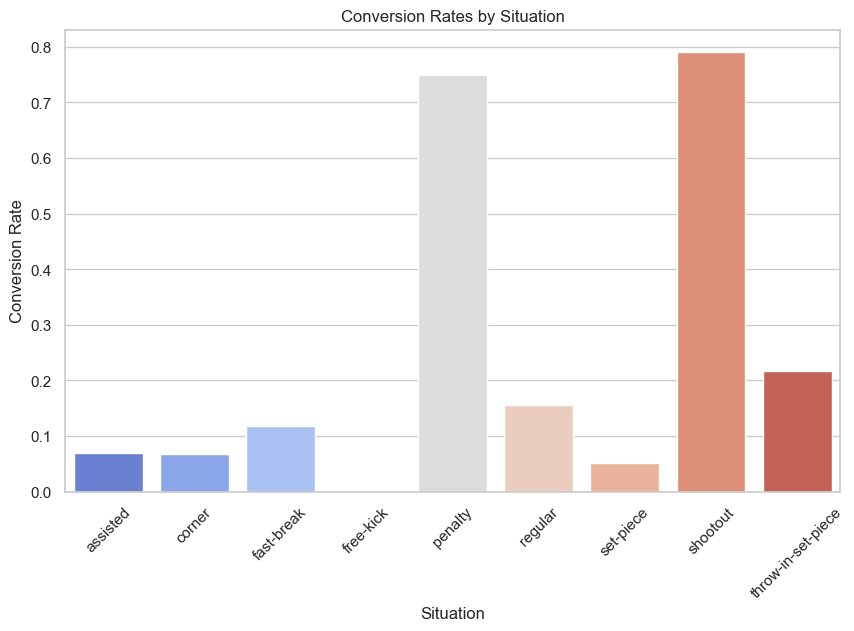

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='situation', y='conversion_rate', data=conversion_summary, palette='coolwarm', hue='situation')
plt.title('Conversion Rates by Situation')
plt.xlabel('Situation')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_not_goal = new_df[new_df['is_goal'] == 0]  # Not Goal
df_goal = new_df[new_df['is_goal'] == 1]      # Goal

df_goal_oversampled = resample(df_goal, 
                               replace=True,      
                               n_samples=len(df_not_goal),  
                               random_state=42)   

df_balanced = pd.concat([df_not_goal, df_goal_oversampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced['is_goal'] = (df_balanced['shotType'] == 'goal').astype(int)

feature_cols = ['xg', 'playerCoordinates.x', 'playerCoordinates.y']  # Example features
X = df_balanced[feature_cols]
y = df_balanced['is_goal']

X.fillna(X.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC(kernel='linear')  
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Goal', 'Goal'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
y_scores = model.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

fpr_unique, unique_indices = np.unique(fpr, return_index=True)
tpr_unique = tpr[unique_indices]

fpr_new = np.linspace(fpr_unique.min(), fpr_unique.max(), 300)
interp_tpr = interp1d(fpr_unique, tpr_unique, kind='quadratic')
tpr_smooth = interp_tpr(fpr_new)

plt.figure()
plt.plot(fpr_new, tpr_smooth, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [ ]:
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [ ]:
X_filtered = X.loc[new_df.index]

new_df['cluster'] = kmeans.fit_predict(X_filtered)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
new_df['cluster'] = kmeans.fit_predict(X_filtered)

centroids = kmeans.cluster_centers_
print(centroids)

In [124]:
X.to_csv('x.csv', index=False)

In [125]:
new_df['xgot'] = new_df['xgot'].fillna(0)

In [126]:
kmeans = KMeans(n_clusters=6, random_state=42)
new_df['cluster'] = kmeans.fit_predict(new_df[['xg', 'xgot']])

In [ ]:
# KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42)
new_df['cluster'] = kmeans.fit_predict(new_df[['xg', 'xgot']])

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='xg', y='xgot', hue='cluster', palette='viridis', data=new_df, s=100, edgecolor='w', legend=False)

plt.xlabel('Expected Goals (xG)')
plt.ylabel('Shots on Target (xGoT)')
plt.title('Player Clustering Based on xG and xGoT')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [ ]:
print(pd.crosstab(df['player.position'], new_df['cluster']))

In [ ]:
new_df

In [ ]:
new_df.to_csv('out2.csv', index=False)